# Energy Consumption Prediction - Comprehensive Analysis

## Overview
This notebook implements a complete energy consumption prediction system using multiple machine learning methods:

### Methods Implemented:
1. **Linear Models**: Linear Regression, Ridge, Lasso, ElasticNet
2. **Tree-Based Models**: Decision Tree, Random Forest, Extra Trees, Gradient Boosting
3. **Boosting Models**: XGBoost, LightGBM, CatBoost
4. **Support Vector Machines**: SVR (RBF, Linear, Polynomial kernels)
5. **Nearest Neighbors**: KNN Regressor
6. **Deep Learning**: LSTM, GRU, Multi-layer Perceptron
7. **Time Series**: Prophet, ARIMA
8. **Ensemble Methods**: Voting Regressor, Stacking Regressor

All charts are automatically saved to the `charts/` folder.

In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import kagglehub

# Sklearn - Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

# Sklearn - Linear Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge

# Sklearn - Tree Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor, 
                               GradientBoostingRegressor, AdaBoostRegressor,
                               VotingRegressor, StackingRegressor, BaggingRegressor)

# Sklearn - Other Models
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Sklearn - Metrics
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                              mean_absolute_percentage_error, explained_variance_score)

# Boosting Libraries
import xgboost as xgb
try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not available, skipping...")

try:
    import catboost as cb
    CATBOOST_AVAILABLE = True
except:
    CATBOOST_AVAILABLE = False
    print("CatBoost not available, skipping...")

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Time Series
from prophet import Prophet

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Create charts directory
import os
os.makedirs('charts', exist_ok=True)

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"XGBoost version: {xgb.__version__}")

All libraries imported successfully!
TensorFlow version: 2.20.0
XGBoost version: 3.1.2


## 1. Data Loading and Exploration

**Note:** The dataset is automatically downloaded from Kaggle using `kagglehub`.  
**Dataset:** [Energy Consumption Prediction](https://www.kaggle.com/datasets/mrsimple07/energy-consumption-prediction)

No manual download required - just run the cells below!

In [2]:
print("=" * 80)
print("AUTOMATIC DATASET DOWNLOAD FROM KAGGLE")
print("=" * 80)
print("\nDataset: mrsimple07/energy-consumption-prediction")
print("Source: https://www.kaggle.com/datasets/mrsimple07/energy-consumption-prediction")
print("\nDownloading...")

# Download latest version from Kaggle
dataset_path = kagglehub.dataset_download("mrsimple07/energy-consumption-prediction")

print(f"\n✓ Dataset downloaded successfully!")
print(f"✓ Path: {dataset_path}")

# Find the CSV file in the downloaded path
import glob
csv_files = glob.glob(os.path.join(dataset_path, "*.csv"))

if csv_files:
    DATA_FILE = csv_files[0]
    print(f"✓ Found CSV file: {os.path.basename(DATA_FILE)}")
    print(f"✓ Full path: {DATA_FILE}")
else:
    raise FileNotFoundError("No CSV file found in the downloaded dataset!")

print("\n" + "=" * 80)
print("DOWNLOAD COMPLETE - Ready to load data!")
print("=" * 80)

AUTOMATIC DATASET DOWNLOAD FROM KAGGLE

Dataset: mrsimple07/energy-consumption-prediction
Source: https://www.kaggle.com/datasets/mrsimple07/energy-consumption-prediction

Downloading...

✓ Dataset downloaded successfully!
✓ Path: /Users/ismatsamadov/.cache/kagglehub/datasets/mrsimple07/energy-consumption-prediction/versions/1
✓ Found CSV file: Energy_consumption.csv
✓ Full path: /Users/ismatsamadov/.cache/kagglehub/datasets/mrsimple07/energy-consumption-prediction/versions/1/Energy_consumption.csv

DOWNLOAD COMPLETE - Ready to load data!


In [3]:
# Load the dataset
df = pd.read_csv(DATA_FILE)

print(f"Dataset loaded from: {os.path.basename(DATA_FILE)}")
print(f"Dataset Shape: {df.shape}")
print(f"\nFirst few rows:")
df.head(10)

Dataset loaded from: Energy_consumption.csv
Dataset Shape: (1000, 11)

First few rows:


,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732
5,2022-01-01 05:00:00,29.576037,36.824263,1871.709180,6,Off,Off,17.626690,Sunday,Yes,84.321885
6,2022-01-01 06:00:00,25.131167,35.709622,1607.001228,6,On,Off,24.264702,Friday,Yes,76.165791
7,2022-01-01 07:00:00,23.182844,31.679920,1633.955330,8,Off,Off,27.517099,Thursday,Yes,74.131906
8,2022-01-01 08:00:00,25.391999,46.399364,1240.309224,6,On,Off,2.307595,Sunday,No,78.206236
9,2022-01-01 09:00:00,22.212549,32.418464,1705.420336,1,On,Off,29.140071,Tuesday,No,77.992214


In [4]:
# Statistical Summary
print("Statistical Summary:")
df.describe()

Statistical Summary:


,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,24.982026,45.395412,1500.052488,4.581000,15.132813,77.055873
std,2.836850,8.518905,288.418873,2.865598,8.745917,8.144112
min,20.007565,30.015975,1000.512661,0.000000,0.006642,53.263278
25%,22.645070,38.297722,1247.108548,2.000000,7.628385,71.544690
50%,24.751637,45.972116,1507.967426,5.000000,15.072296,76.943696
75%,27.418174,52.420066,1740.340165,7.000000,22.884064,82.921742
max,29.998671,59.969085,1999.982252,9.000000,29.965327,99.201120


In [5]:
# Check for missing values
print("Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0])
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# Data types
print(f"\nData types:")
print(df.dtypes)

Missing Values:
Series([], dtype: int64)

Total missing values: 0

Duplicate rows: 0

Data types:
Timestamp             object
Temperature          float64
Humidity             float64
SquareFootage        float64
Occupancy              int64
HVACUsage             object
LightingUsage         object
RenewableEnergy      float64
DayOfWeek             object
Holiday               object
EnergyConsumption    float64
dtype: object


## 2. Exploratory Data Analysis (EDA)

In [6]:
# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract time-based features
df['Hour'] = df['Timestamp'].dt.hour
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month
df['Year'] = df['Timestamp'].dt.year
df['DayOfYear'] = df['Timestamp'].dt.dayofyear
df['WeekOfYear'] = df['Timestamp'].dt.isocalendar().week

print("Time-based features extracted!")
print(f"Date range: {df['Timestamp'].min()} to {df['Timestamp'].max()}")
df.head()

Time-based features extracted!
Date range: 2022-01-01 00:00:00 to 2022-02-11 15:00:00


,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Hour,Day,Month,Year,DayOfYear,WeekOfYear
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373,0,1,1,2022,1,52
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855,1,1,1,2022,1,52
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888,2,1,1,2022,1,52
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850,3,1,1,2022,1,52
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732,4,1,1,2022,1,52


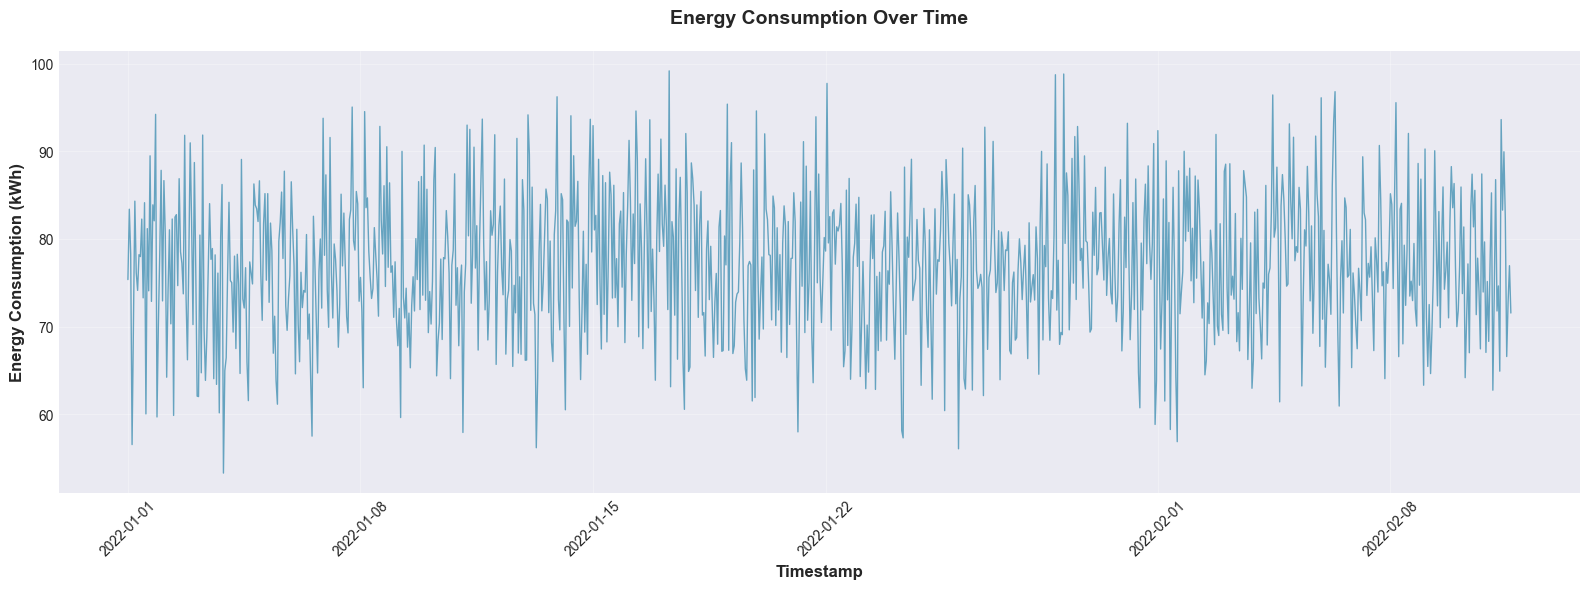

Chart saved: charts/01_energy_consumption_timeseries.png


In [7]:
# Energy Consumption over time
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df['Timestamp'], df['EnergyConsumption'], linewidth=1, alpha=0.7, color='#2E86AB')
ax.set_xlabel('Timestamp', fontsize=12, fontweight='bold')
ax.set_ylabel('Energy Consumption (kWh)', fontsize=12, fontweight='bold')
ax.set_title('Energy Consumption Over Time', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('charts/01_energy_consumption_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()
print("Chart saved: charts/01_energy_consumption_timeseries.png")

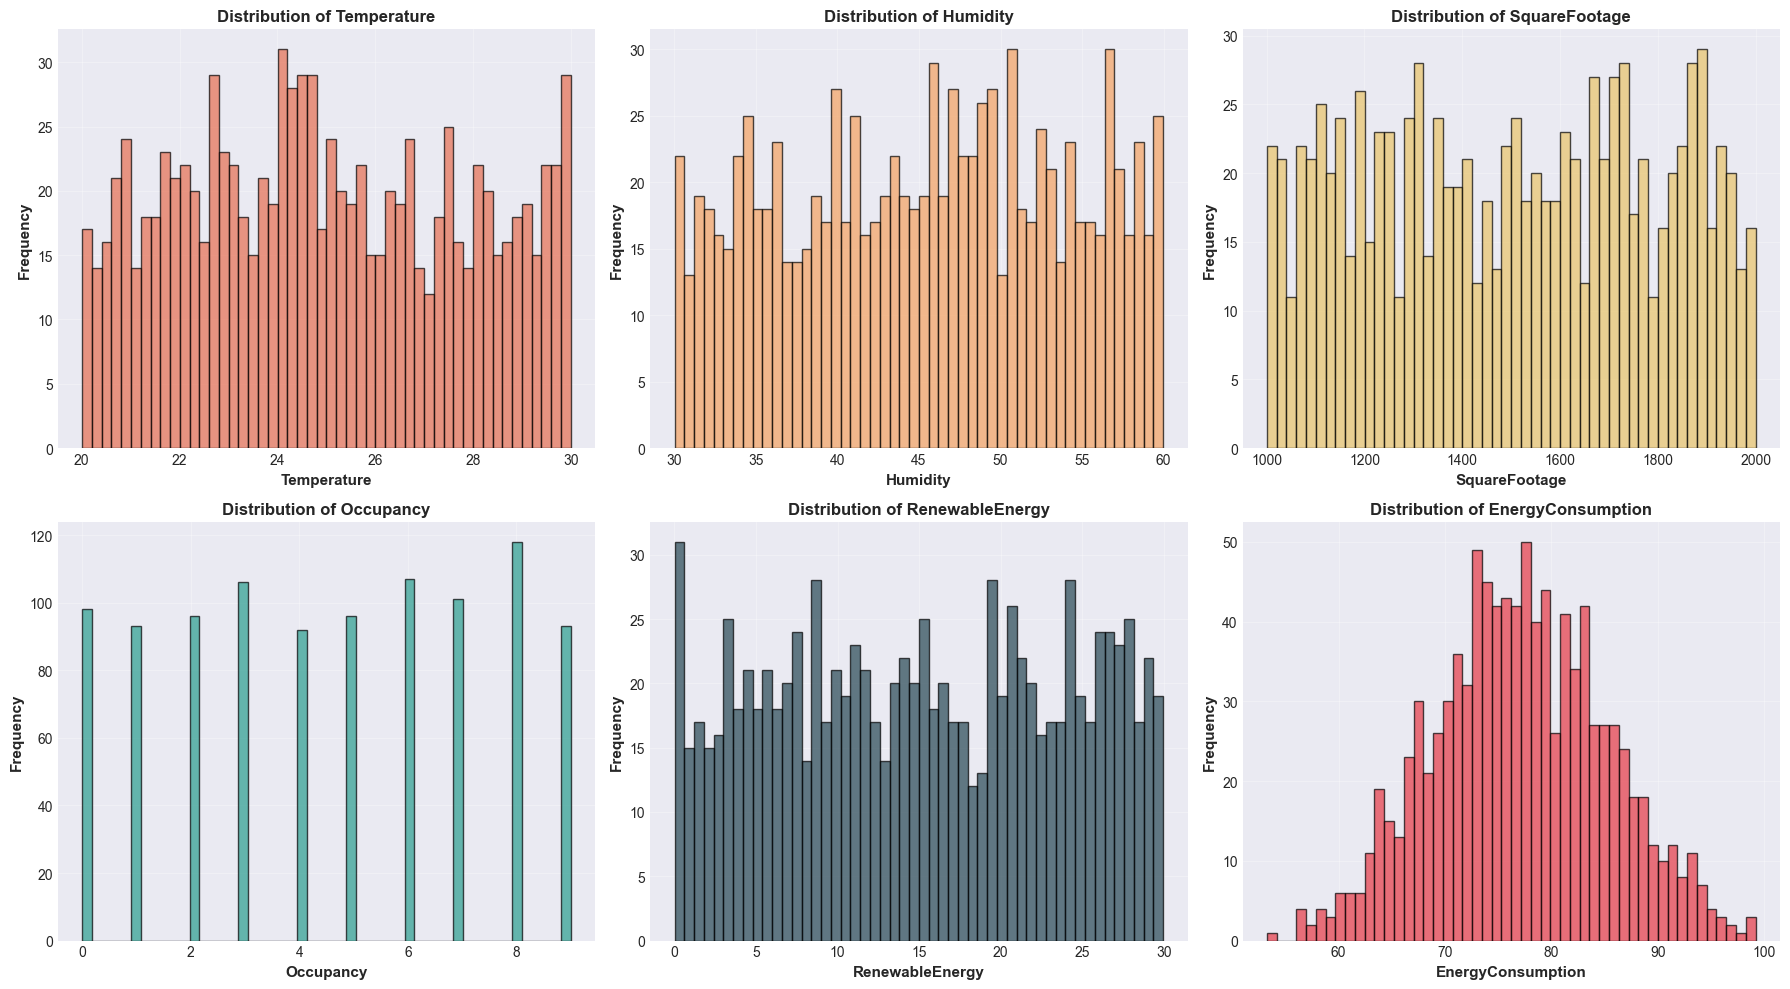

Chart saved: charts/02_feature_distributions.png


In [8]:
# Distribution plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
numerical_cols = ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'EnergyConsumption']
colors = ['#E76F51', '#F4A261', '#E9C46A', '#2A9D8F', '#264653', '#E63946']

for idx, (col, color) in enumerate(zip(numerical_cols, colors)):
    ax = axes[idx // 3, idx % 3]
    ax.hist(df[col], bins=50, color=color, alpha=0.7, edgecolor='black')
    ax.set_xlabel(col, fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('charts/02_feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print("Chart saved: charts/02_feature_distributions.png")

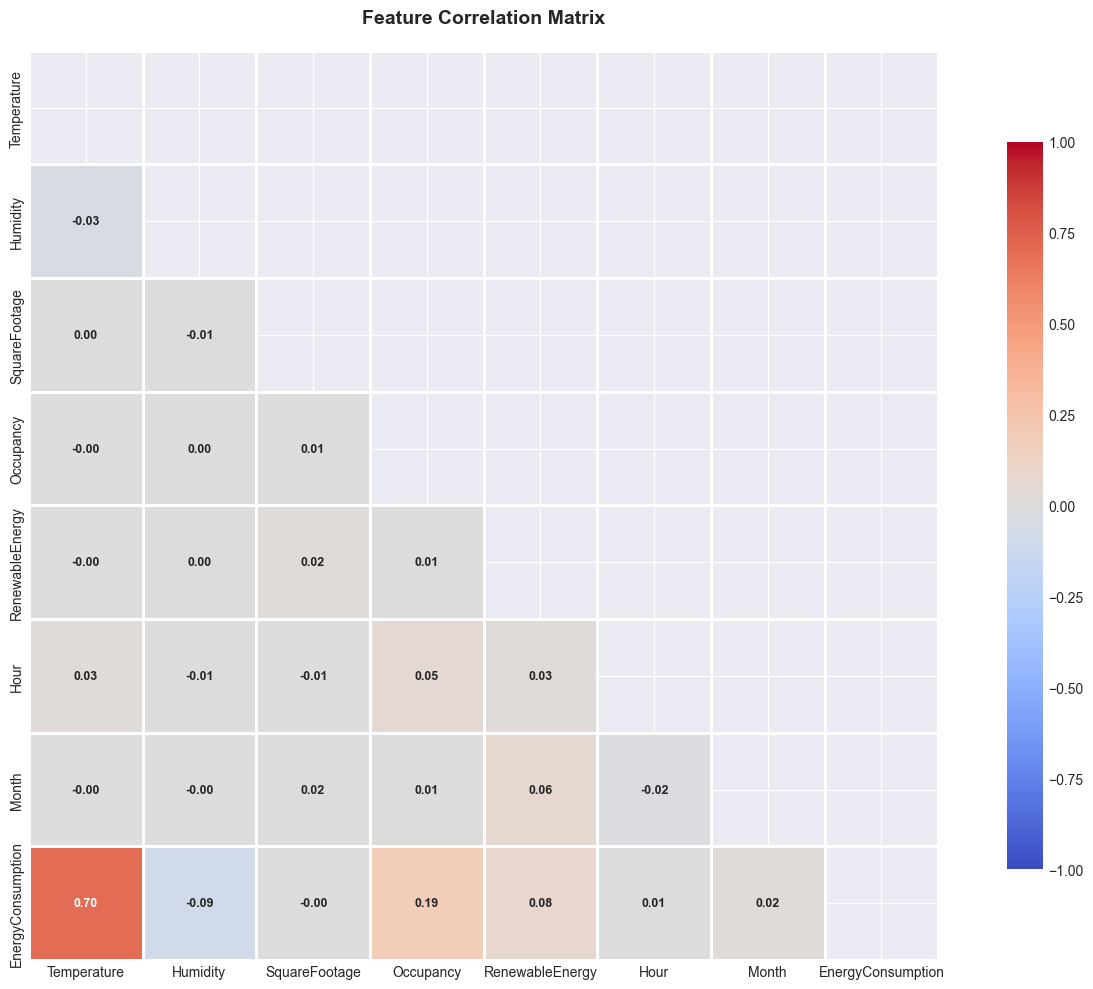

Chart saved: charts/03_correlation_heatmap.png


In [9]:
# Correlation heatmap
plt.figure(figsize=(14, 10))
correlation_cols = ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 
                    'RenewableEnergy', 'Hour', 'Month', 'EnergyConsumption']
correlation_matrix = df[correlation_cols].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='coolwarm', square=True, linewidths=1, 
            cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1,
            annot_kws={'size': 9, 'weight': 'bold'})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('charts/03_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("Chart saved: charts/03_correlation_heatmap.png")

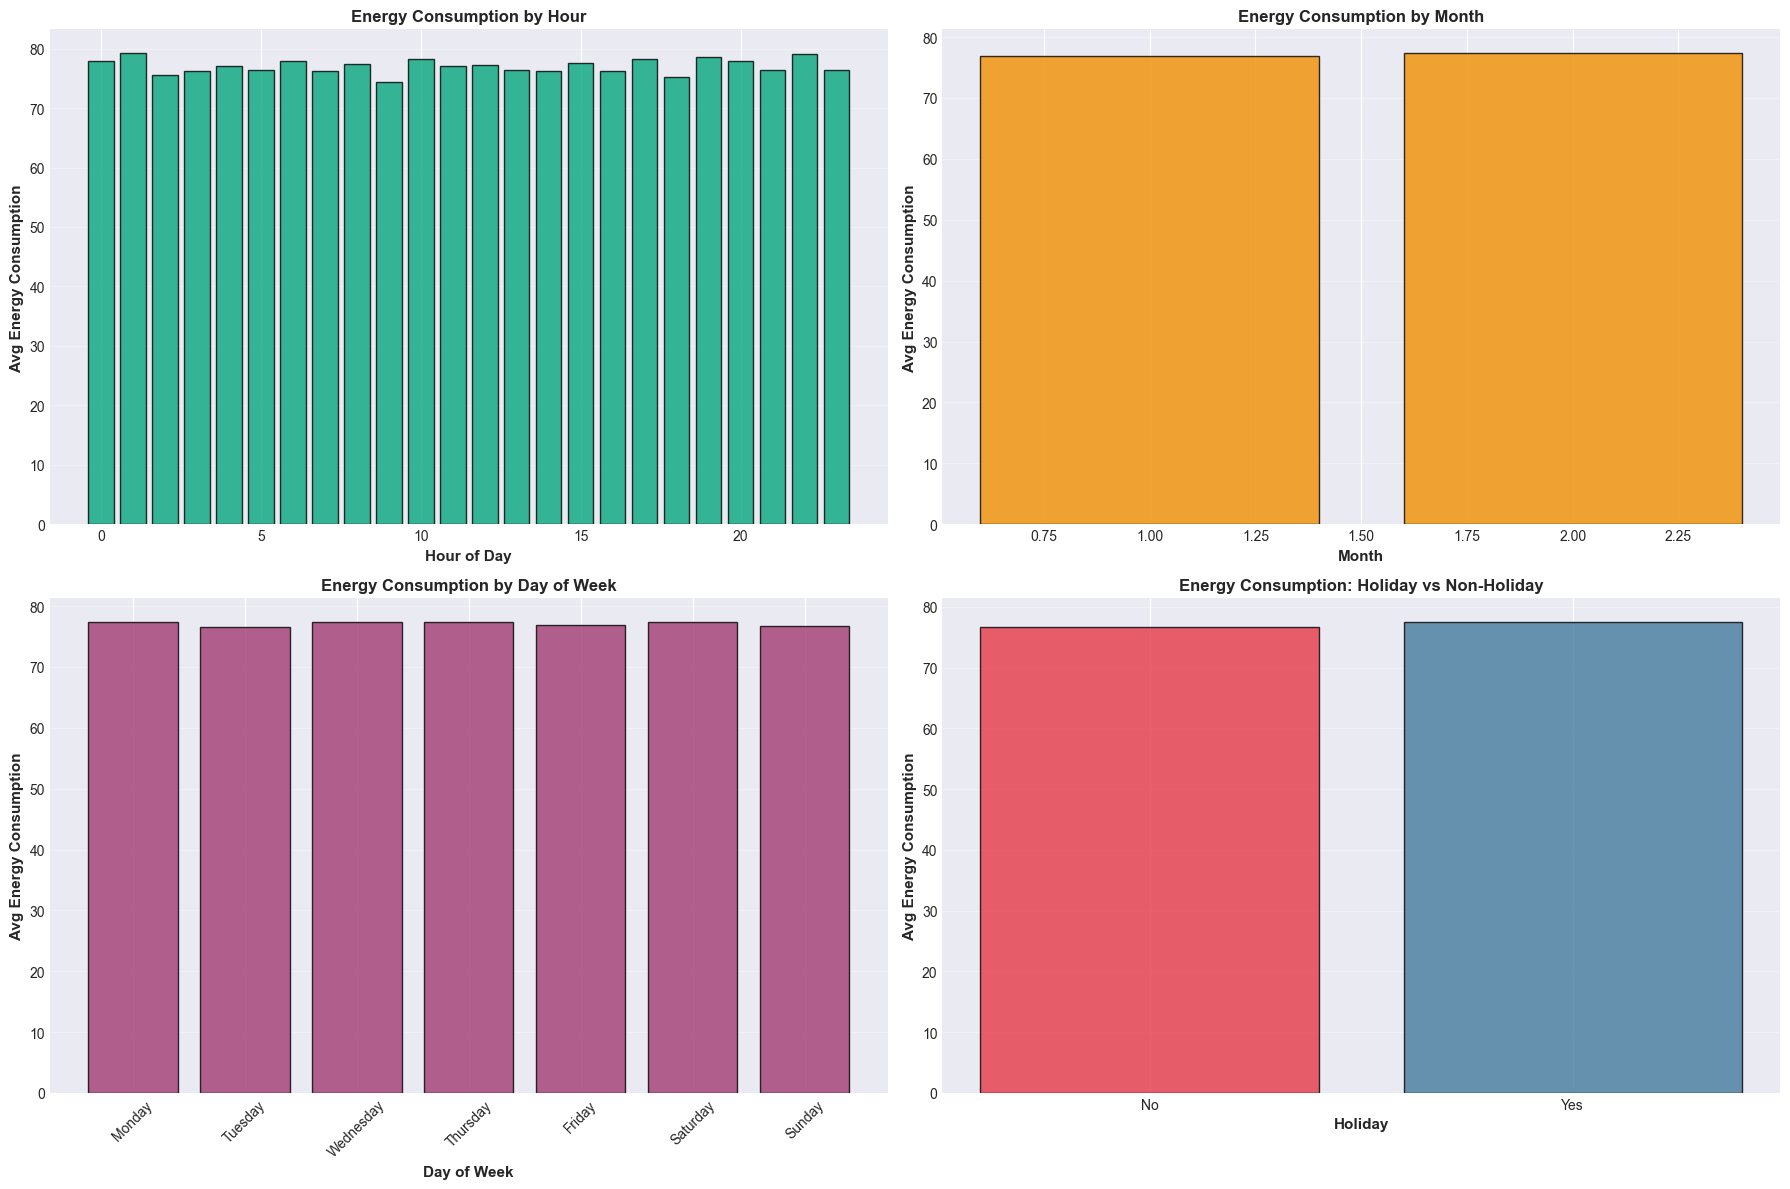

Chart saved: charts/04_consumption_patterns.png


In [10]:
# Energy consumption patterns
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Hourly pattern
hourly_avg = df.groupby('Hour')['EnergyConsumption'].mean()
axes[0, 0].bar(hourly_avg.index, hourly_avg.values, color='#06A77D', alpha=0.8, edgecolor='black')
axes[0, 0].set_xlabel('Hour of Day', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Avg Energy Consumption', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Energy Consumption by Hour', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Monthly pattern
monthly_avg = df.groupby('Month')['EnergyConsumption'].mean()
axes[0, 1].bar(monthly_avg.index, monthly_avg.values, color='#F18F01', alpha=0.8, edgecolor='black')
axes[0, 1].set_xlabel('Month', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Avg Energy Consumption', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Energy Consumption by Month', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Day of week pattern
day_avg = df.groupby('DayOfWeek')['EnergyConsumption'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
axes[1, 0].bar(range(len(day_avg)), day_avg.values, color='#A23B72', alpha=0.8, edgecolor='black')
axes[1, 0].set_xticks(range(len(day_avg)))
axes[1, 0].set_xticklabels(day_avg.index, rotation=45)
axes[1, 0].set_xlabel('Day of Week', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Avg Energy Consumption', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Energy Consumption by Day of Week', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Holiday vs Non-Holiday
holiday_avg = df.groupby('Holiday')['EnergyConsumption'].mean()
axes[1, 1].bar(holiday_avg.index, holiday_avg.values, color=['#E63946', '#457B9D'], 
               alpha=0.8, edgecolor='black')
axes[1, 1].set_xlabel('Holiday', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Avg Energy Consumption', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Energy Consumption: Holiday vs Non-Holiday', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('charts/04_consumption_patterns.png', dpi=300, bbox_inches='tight')
plt.show()
print("Chart saved: charts/04_consumption_patterns.png")

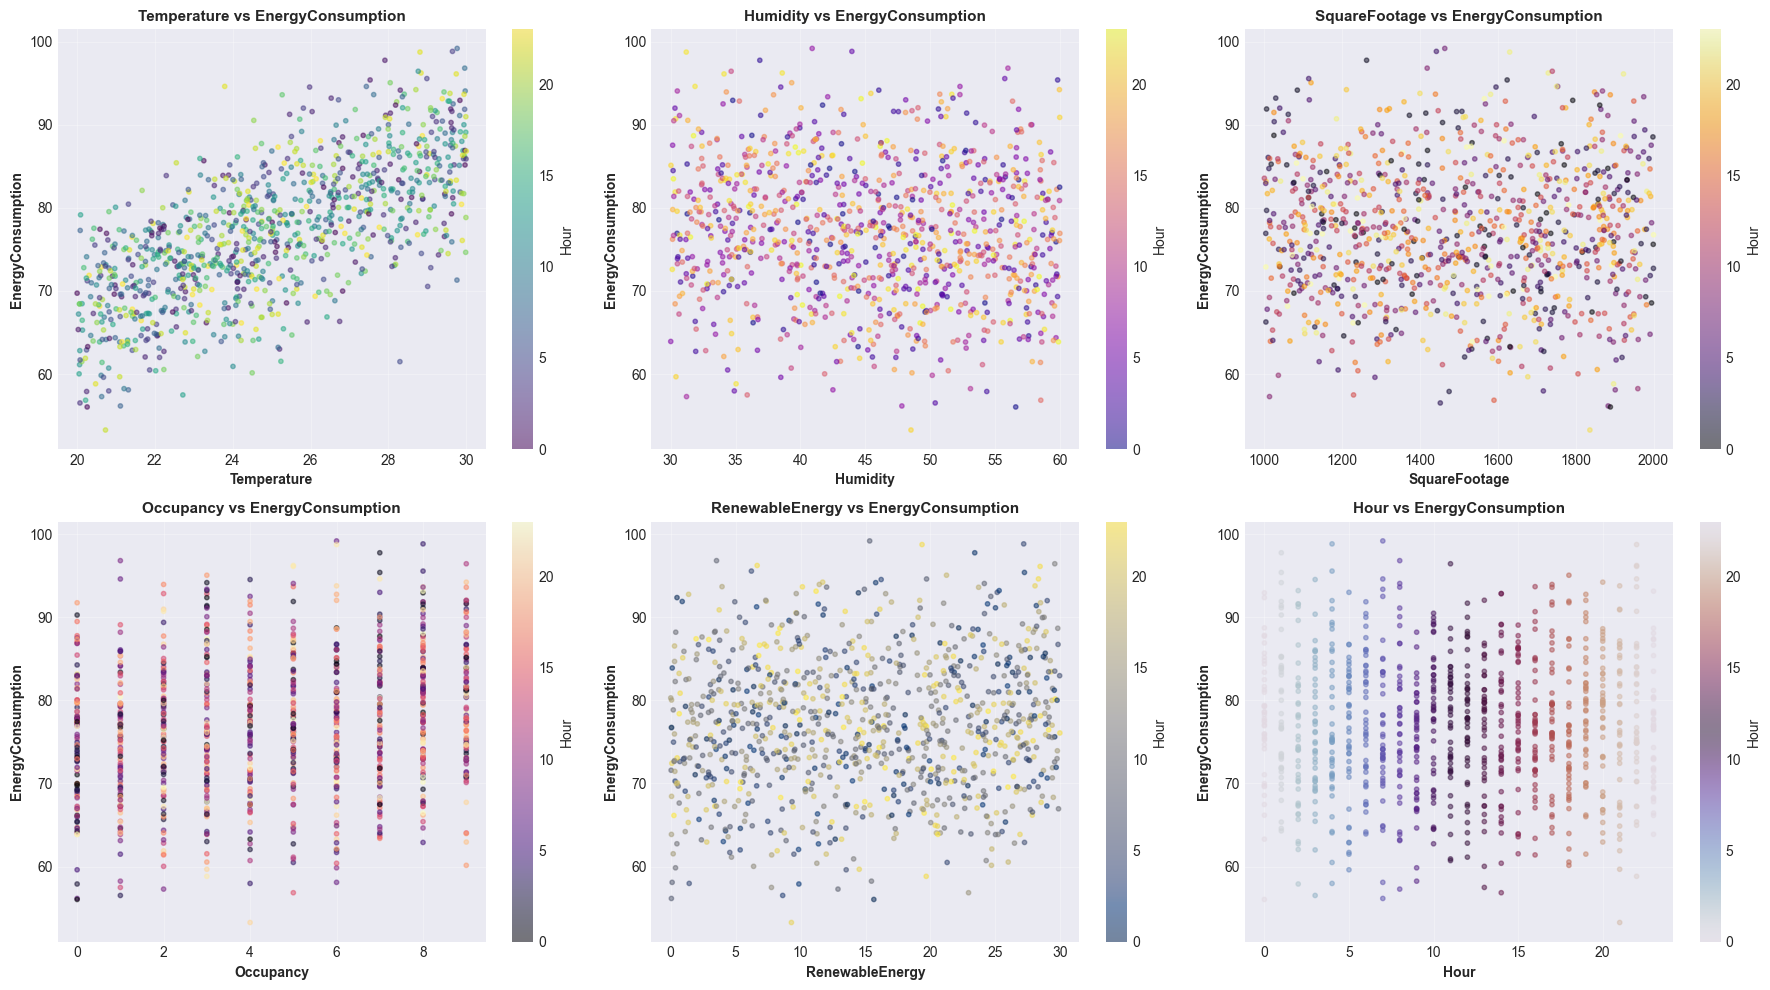

Chart saved: charts/05_scatter_relationships.png


In [11]:
# Scatter plots - relationships
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

scatter_pairs = [
    ('Temperature', 'EnergyConsumption'),
    ('Humidity', 'EnergyConsumption'),
    ('SquareFootage', 'EnergyConsumption'),
    ('Occupancy', 'EnergyConsumption'),
    ('RenewableEnergy', 'EnergyConsumption'),
    ('Hour', 'EnergyConsumption')
]

colors_scatter = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'twilight']

for idx, ((x_col, y_col), cmap) in enumerate(zip(scatter_pairs, colors_scatter)):
    ax = axes[idx // 3, idx % 3]
    scatter = ax.scatter(df[x_col], df[y_col], c=df['Hour'], 
                         cmap=cmap, alpha=0.5, s=10)
    ax.set_xlabel(x_col, fontsize=10, fontweight='bold')
    ax.set_ylabel(y_col, fontsize=10, fontweight='bold')
    ax.set_title(f'{x_col} vs {y_col}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Hour')

plt.tight_layout()
plt.savefig('charts/05_scatter_relationships.png', dpi=300, bbox_inches='tight')
plt.show()
print("Chart saved: charts/05_scatter_relationships.png")

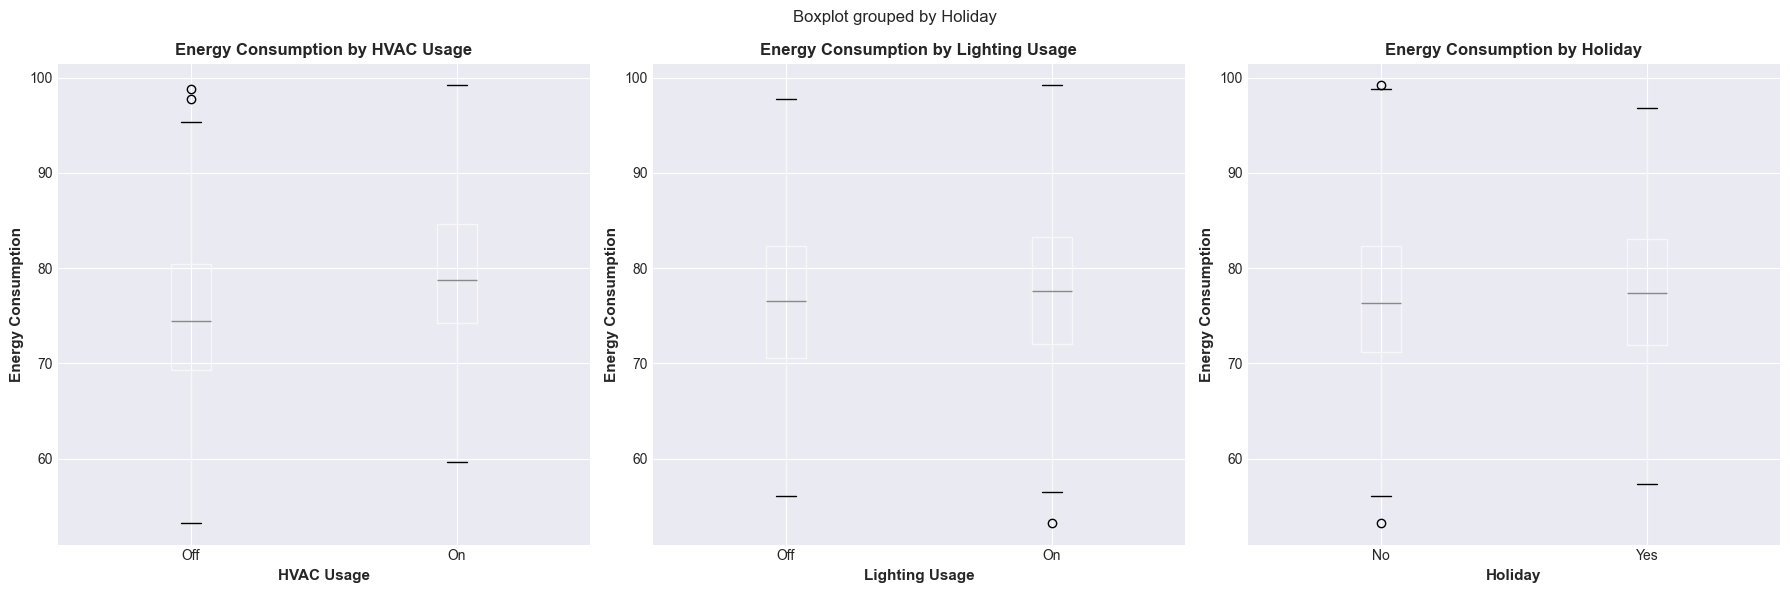

Chart saved: charts/06_categorical_boxplots.png


In [12]:
# Box plots for categorical features
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# HVAC Usage
df.boxplot(column='EnergyConsumption', by='HVACUsage', ax=axes[0])
axes[0].set_xlabel('HVAC Usage', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Energy Consumption', fontsize=11, fontweight='bold')
axes[0].set_title('Energy Consumption by HVAC Usage', fontsize=12, fontweight='bold')
axes[0].get_figure().suptitle('')

# Lighting Usage
df.boxplot(column='EnergyConsumption', by='LightingUsage', ax=axes[1])
axes[1].set_xlabel('Lighting Usage', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Energy Consumption', fontsize=11, fontweight='bold')
axes[1].set_title('Energy Consumption by Lighting Usage', fontsize=12, fontweight='bold')

# Holiday
df.boxplot(column='EnergyConsumption', by='Holiday', ax=axes[2])
axes[2].set_xlabel('Holiday', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Energy Consumption', fontsize=11, fontweight='bold')
axes[2].set_title('Energy Consumption by Holiday', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('charts/06_categorical_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()
print("Chart saved: charts/06_categorical_boxplots.png")

## 3. Feature Engineering

In [13]:
# Encode categorical variables
le_hvac = LabelEncoder()
le_lighting = LabelEncoder()
le_day = LabelEncoder()
le_holiday = LabelEncoder()

df['HVACUsage_encoded'] = le_hvac.fit_transform(df['HVACUsage'])
df['LightingUsage_encoded'] = le_lighting.fit_transform(df['LightingUsage'])
df['DayOfWeek_encoded'] = le_day.fit_transform(df['DayOfWeek'])
df['Holiday_encoded'] = le_holiday.fit_transform(df['Holiday'])

# Cyclical encoding for time features
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek_encoded'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek_encoded'] / 7)

# Interaction features
df['Temp_Humidity'] = df['Temperature'] * df['Humidity']
df['Temp_Squared'] = df['Temperature'] ** 2
df['HVAC_Lighting'] = df['HVACUsage_encoded'] * df['LightingUsage_encoded']
df['SquareFootage_Occupancy'] = df['SquareFootage'] * df['Occupancy']

# Lag features
df['EnergyConsumption_lag1'] = df['EnergyConsumption'].shift(1)
df['EnergyConsumption_lag24'] = df['EnergyConsumption'].shift(24)
df['EnergyConsumption_lag168'] = df['EnergyConsumption'].shift(168)  # 1 week

# Rolling statistics
df['EnergyConsumption_rolling_mean_24h'] = df['EnergyConsumption'].rolling(window=24, min_periods=1).mean()
df['EnergyConsumption_rolling_std_24h'] = df['EnergyConsumption'].rolling(window=24, min_periods=1).std()
df['EnergyConsumption_rolling_max_24h'] = df['EnergyConsumption'].rolling(window=24, min_periods=1).max()
df['EnergyConsumption_rolling_min_24h'] = df['EnergyConsumption'].rolling(window=24, min_periods=1).min()

# Fill NaN values
df.fillna(method='bfill', inplace=True)

print("Feature engineering completed!")
print(f"Total features: {df.shape[1]}")
print("\nNew features created:")
new_features = [col for col in df.columns if col not in ['Timestamp', 'HVACUsage', 'LightingUsage', 
                                                           'DayOfWeek', 'Holiday', 'EnergyConsumption']]
print(new_features)

Feature engineering completed!
Total features: 38

New features created:
['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'Hour', 'Day', 'Month', 'Year', 'DayOfYear', 'WeekOfYear', 'HVACUsage_encoded', 'LightingUsage_encoded', 'DayOfWeek_encoded', 'Holiday_encoded', 'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Temp_Humidity', 'Temp_Squared', 'HVAC_Lighting', 'SquareFootage_Occupancy', 'EnergyConsumption_lag1', 'EnergyConsumption_lag24', 'EnergyConsumption_lag168', 'EnergyConsumption_rolling_mean_24h', 'EnergyConsumption_rolling_std_24h', 'EnergyConsumption_rolling_max_24h', 'EnergyConsumption_rolling_min_24h']


## 4. Data Preparation for Modeling

In [14]:
# Define feature sets
feature_cols = [
    'Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy',
    'HVACUsage_encoded', 'LightingUsage_encoded', 'Holiday_encoded',
    'Hour', 'Month', 'DayOfYear', 'WeekOfYear',
    'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos',
    'Temp_Humidity', 'Temp_Squared', 'HVAC_Lighting', 'SquareFootage_Occupancy',
    'EnergyConsumption_lag1', 'EnergyConsumption_lag24', 'EnergyConsumption_lag168',
    'EnergyConsumption_rolling_mean_24h', 'EnergyConsumption_rolling_std_24h',
    'EnergyConsumption_rolling_max_24h', 'EnergyConsumption_rolling_min_24h'
]

X = df[feature_cols].values
y = df['EnergyConsumption'].values

# Time-based split (80-20)
split_idx = int(len(df) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
df_train, df_test = df[:split_idx], df[split_idx:]

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Features: {len(feature_cols)}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData preparation complete!")

Training set: (800, 29)
Test set: (200, 29)
Features: 29

Data preparation complete!


In [15]:
# Helper function for evaluation
def evaluate_model(name, y_true, y_pred, verbose=True):
    """Calculate comprehensive metrics for model evaluation"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    evs = explained_variance_score(y_true, y_pred)
    
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape,
        'EVS': evs
    }
    
    if verbose:
        print(f"\n{name} Results:")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE:  {mae:.4f}")
        print(f"  R²:   {r2:.4f}")
        print(f"  MAPE: {mape:.2f}%")
    
    return metrics

# Dictionary to store all results
models_results = {}

print("Helper functions ready!")

Helper functions ready!


## 5. Model Training
### 5.1 Linear Models

In [16]:
# Linear Regression
print("Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
models_results['Linear Regression'] = evaluate_model('Linear Regression', y_test, lr_pred)
models_results['Linear Regression']['predictions'] = lr_pred

Training Linear Regression...

Linear Regression Results:
  RMSE: 4.9906
  MAE:  4.0450
  R²:   0.5936
  MAPE: 5.32%


In [17]:
# Ridge Regression
print("Training Ridge Regression...")
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
ridge_pred = ridge_model.predict(X_test_scaled)
models_results['Ridge'] = evaluate_model('Ridge', y_test, ridge_pred)
models_results['Ridge']['predictions'] = ridge_pred

Training Ridge Regression...

Ridge Results:
  RMSE: 4.9748
  MAE:  4.0340
  R²:   0.5962
  MAPE: 5.31%


In [18]:
# Lasso Regression
print("Training Lasso Regression...")
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_scaled, y_train)
lasso_pred = lasso_model.predict(X_test_scaled)
models_results['Lasso'] = evaluate_model('Lasso', y_test, lasso_pred)
models_results['Lasso']['predictions'] = lasso_pred

Training Lasso Regression...

Lasso Results:
  RMSE: 4.9265
  MAE:  4.0414
  R²:   0.6040
  MAPE: 5.27%


In [19]:
# ElasticNet
print("Training ElasticNet...")
elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_model.fit(X_train_scaled, y_train)
elastic_pred = elastic_model.predict(X_test_scaled)
models_results['ElasticNet'] = evaluate_model('ElasticNet', y_test, elastic_pred)
models_results['ElasticNet']['predictions'] = elastic_pred

Training ElasticNet...

ElasticNet Results:
  RMSE: 4.9020
  MAE:  4.0034
  R²:   0.6079
  MAPE: 5.25%


In [20]:
# Bayesian Ridge
print("Training Bayesian Ridge...")
bayesian_model = BayesianRidge()
bayesian_model.fit(X_train_scaled, y_train)
bayesian_pred = bayesian_model.predict(X_test_scaled)
models_results['Bayesian Ridge'] = evaluate_model('Bayesian Ridge', y_test, bayesian_pred)
models_results['Bayesian Ridge']['predictions'] = bayesian_pred

Training Bayesian Ridge...

Bayesian Ridge Results:
  RMSE: 4.9405
  MAE:  4.0062
  R²:   0.6017
  MAPE: 5.28%


### 5.2 Tree-Based Models

In [21]:
# Decision Tree
print("Training Decision Tree...")
dt_model = DecisionTreeRegressor(max_depth=15, min_samples_split=10, random_state=42)
dt_model.fit(X_train_scaled, y_train)
dt_pred = dt_model.predict(X_test_scaled)
models_results['Decision Tree'] = evaluate_model('Decision Tree', y_test, dt_pred)
models_results['Decision Tree']['predictions'] = dt_pred

Training Decision Tree...

Decision Tree Results:
  RMSE: 8.0629
  MAE:  6.3766
  R²:   -0.0608
  MAPE: 8.19%


In [22]:
# Random Forest
print("Training Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, 
                                  min_samples_split=5, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
models_results['Random Forest'] = evaluate_model('Random Forest', y_test, rf_pred)
models_results['Random Forest']['predictions'] = rf_pred

Training Random Forest...

Random Forest Results:
  RMSE: 5.1083
  MAE:  4.1759
  R²:   0.5742
  MAPE: 5.41%


In [23]:
# Extra Trees
print("Training Extra Trees...")
et_model = ExtraTreesRegressor(n_estimators=100, max_depth=20, 
                                min_samples_split=5, random_state=42, n_jobs=-1)
et_model.fit(X_train_scaled, y_train)
et_pred = et_model.predict(X_test_scaled)
models_results['Extra Trees'] = evaluate_model('Extra Trees', y_test, et_pred)
models_results['Extra Trees']['predictions'] = et_pred

Training Extra Trees...

Extra Trees Results:
  RMSE: 5.3987
  MAE:  4.3939
  R²:   0.5244
  MAPE: 5.68%


In [24]:
# Gradient Boosting
print("Training Gradient Boosting...")
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, 
                                      learning_rate=0.1, random_state=42)
gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)
models_results['Gradient Boosting'] = evaluate_model('Gradient Boosting', y_test, gb_pred)
models_results['Gradient Boosting']['predictions'] = gb_pred

Training Gradient Boosting...

Gradient Boosting Results:
  RMSE: 5.2574
  MAE:  4.2360
  R²:   0.5490
  MAPE: 5.50%


In [25]:
# AdaBoost
print("Training AdaBoost...")
ada_model = AdaBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
ada_model.fit(X_train_scaled, y_train)
ada_pred = ada_model.predict(X_test_scaled)
models_results['AdaBoost'] = evaluate_model('AdaBoost', y_test, ada_pred)
models_results['AdaBoost']['predictions'] = ada_pred

Training AdaBoost...

AdaBoost Results:
  RMSE: 4.8340
  MAE:  3.9380
  R²:   0.6187
  MAPE: 5.12%


### 5.3 Boosting Models

In [26]:
# XGBoost
print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=8, learning_rate=0.1,
                             subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
models_results['XGBoost'] = evaluate_model('XGBoost', y_test, xgb_pred)
models_results['XGBoost']['predictions'] = xgb_pred

Training XGBoost...

XGBoost Results:
  RMSE: 5.2822
  MAE:  4.2729
  R²:   0.5447
  MAPE: 5.54%


In [27]:
# LightGBM
if LIGHTGBM_AVAILABLE:
    print("Training LightGBM...")
    lgb_model = lgb.LGBMRegressor(n_estimators=100, max_depth=8, learning_rate=0.1,
                                   random_state=42, verbose=-1)
    lgb_model.fit(X_train_scaled, y_train)
    lgb_pred = lgb_model.predict(X_test_scaled)
    models_results['LightGBM'] = evaluate_model('LightGBM', y_test, lgb_pred)
    models_results['LightGBM']['predictions'] = lgb_pred
else:
    print("LightGBM not available, skipping...")

Training LightGBM...

LightGBM Results:
  RMSE: 5.0562
  MAE:  4.1272
  R²:   0.5828
  MAPE: 5.37%


In [28]:
# CatBoost
if CATBOOST_AVAILABLE:
    print("Training CatBoost...")
    cat_model = cb.CatBoostRegressor(iterations=100, depth=8, learning_rate=0.1,
                                      random_state=42, verbose=0)
    cat_model.fit(X_train_scaled, y_train)
    cat_pred = cat_model.predict(X_test_scaled)
    models_results['CatBoost'] = evaluate_model('CatBoost', y_test, cat_pred)
    models_results['CatBoost']['predictions'] = cat_pred
else:
    print("CatBoost not available, skipping...")

Training CatBoost...

CatBoost Results:
  RMSE: 4.9687
  MAE:  4.0067
  R²:   0.5971
  MAPE: 5.21%


### 5.4 Support Vector Machines

In [29]:
# SVR - RBF Kernel
print("Training SVR (RBF)...")
svr_rbf_model = SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1)
svr_rbf_model.fit(X_train_scaled, y_train)
svr_rbf_pred = svr_rbf_model.predict(X_test_scaled)
models_results['SVR (RBF)'] = evaluate_model('SVR (RBF)', y_test, svr_rbf_pred)
models_results['SVR (RBF)']['predictions'] = svr_rbf_pred

Training SVR (RBF)...

SVR (RBF) Results:
  RMSE: 5.9614
  MAE:  4.7606
  R²:   0.4201
  MAPE: 6.22%


In [30]:
# SVR - Linear Kernel
print("Training SVR (Linear)...")
svr_linear_model = SVR(kernel='linear', C=100, epsilon=0.1)
svr_linear_model.fit(X_train_scaled, y_train)
svr_linear_pred = svr_linear_model.predict(X_test_scaled)
models_results['SVR (Linear)'] = evaluate_model('SVR (Linear)', y_test, svr_linear_pred)
models_results['SVR (Linear)']['predictions'] = svr_linear_pred

Training SVR (Linear)...

SVR (Linear) Results:
  RMSE: 4.9563
  MAE:  4.0723
  R²:   0.5991
  MAPE: 5.33%


In [31]:
# SVR - Polynomial Kernel
print("Training SVR (Poly)...")
svr_poly_model = SVR(kernel='poly', degree=3, C=100, epsilon=0.1)
svr_poly_model.fit(X_train_scaled, y_train)
svr_poly_pred = svr_poly_model.predict(X_test_scaled)
models_results['SVR (Poly)'] = evaluate_model('SVR (Poly)', y_test, svr_poly_pred)
models_results['SVR (Poly)']['predictions'] = svr_poly_pred

Training SVR (Poly)...

SVR (Poly) Results:
  RMSE: 14.1908
  MAE:  10.8459
  R²:   -2.2861
  MAPE: 14.11%


### 5.5 K-Nearest Neighbors

In [32]:
# KNN
print("Training KNN...")
knn_model = KNeighborsRegressor(n_neighbors=10, weights='distance')
knn_model.fit(X_train_scaled, y_train)
knn_pred = knn_model.predict(X_test_scaled)
models_results['KNN'] = evaluate_model('KNN', y_test, knn_pred)
models_results['KNN']['predictions'] = knn_pred

Training KNN...

KNN Results:
  RMSE: 6.3476
  MAE:  5.1868
  R²:   0.3425
  MAPE: 6.66%


### 5.6 Deep Learning Models

In [33]:
# Multi-Layer Perceptron (MLP)
print("Building MLP model...")
mlp_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

mlp_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
print(mlp_model.summary())

Building MLP model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,481 (205.00 KB)

 Trainable params: 51,713 (202.00 KB)

 Non-trainable params: 768 (3.00 KB)

None


In [34]:
# Train MLP
print("Training MLP...")
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

mlp_history = mlp_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

mlp_pred = mlp_model.predict(X_test_scaled, verbose=0).flatten()
models_results['MLP'] = evaluate_model('MLP', y_test, mlp_pred)
models_results['MLP']['predictions'] = mlp_pred
models_results['MLP']['history'] = mlp_history

Training MLP...
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5872.5894 - mae: 76.1973 - val_loss: 5982.3193 - val_mae: 76.9377 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5561.5039 - mae: 74.1368 - val_loss: 5864.7246 - val_mae: 76.1751 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5159.4917 - mae: 71.3730 - val_loss: 5690.5303 - val_mae: 75.0378 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4604.7095 - mae: 67.3441 - val_loss: 5386.6367 - val_mae: 73.0106 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3833.9856 - mae: 61.2340 - val_loss: 4846.2627 - val_mae: 69.2177 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2809.5808 - mae: 51.4973 - val_loss: 3991.0735 - val_mae: 62.5555 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1679.1237 - mae: 37.3005 - val

In [35]:
# Prepare sequence data for LSTM/GRU
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 24
X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train, time_steps)
X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test, time_steps)

print(f"LSTM/GRU Training shape: {X_train_lstm.shape}")
print(f"LSTM/GRU Test shape: {X_test_lstm.shape}")

LSTM/GRU Training shape: (776, 24, 29)
LSTM/GRU Test shape: (176, 24, 29)


In [36]:
# LSTM Model
print("Building LSTM model...")
lstm_model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(time_steps, X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
print(lstm_model.summary())

Building LSTM model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        80,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,265 (559.63 KB)

 Trainable params: 143,265 (559.63 KB)

 Non-trainable params: 0 (0.00 B)

None


In [37]:
# Train LSTM
print("Training LSTM...")
lstm_history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

lstm_pred = lstm_model.predict(X_test_lstm, verbose=0).flatten()
models_results['LSTM'] = evaluate_model('LSTM', y_test_lstm, lstm_pred)
models_results['LSTM']['predictions'] = lstm_pred
models_results['LSTM']['history'] = lstm_history

Training LSTM...
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 5920.9434 - mae: 76.5062 - val_loss: 5648.3716 - val_mae: 74.7182 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2587.1802 - mae: 42.9599 - val_loss: 1089.3765 - val_mae: 25.4847 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1009.6431 - mae: 25.1284 - val_loss: 713.6548 - val_mae: 22.5424 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 579.0853 - mae: 19.2999 - val_loss: 312.4654 - val_mae: 14.6881 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 456.8985 - mae: 17.0385 - val_loss: 215.4099 - val_mae: 12.1094 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 436.0668 - mae: 16.1999 - val_loss: 171.9024 - val_mae: 10.4289 - learning_rate: 5.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 330.7731 - mae: 13.9356 - val_los

In [38]:
# GRU Model
print("Building GRU model...")
gru_model = Sequential([
    GRU(128, activation='relu', return_sequences=True, input_shape=(time_steps, X_train_lstm.shape[2])),
    Dropout(0.2),
    GRU(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    GRU(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
print(gru_model.summary())

Building GRU model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 24, 128)        │        61,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 24, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,257 (422.88 KB)

 Trainable params: 108,257 (422.88 KB)

 Non-trainable params: 0 (0.00 B)

None


In [39]:
# Train GRU
print("Training GRU...")
gru_history = gru_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

gru_pred = gru_model.predict(X_test_lstm, verbose=0).flatten()
models_results['GRU'] = evaluate_model('GRU', y_test_lstm, gru_pred)
models_results['GRU']['predictions'] = gru_pred
models_results['GRU']['history'] = gru_history

Training GRU...
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 5937.5977 - mae: 76.6161 - val_loss: 5959.2446 - val_mae: 76.7762 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5623.2432 - mae: 74.5168 - val_loss: 4926.5122 - val_mae: 69.7069 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1657.0004 - mae: 34.3110 - val_loss: 2233.6550 - val_mae: 44.7239 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 439.0830 - mae: 16.9494 - val_loss: 1804.5432 - val_mae: 39.6150 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 291.2463 - mae: 13.7842 - val_loss: 1205.1576 - val_mae: 29.6513 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 272.3795 - mae: 12.9916 - val_loss: 1156.3759 - val_mae: 29.0155 - learning_rate: 5.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 237.4308 - mae: 12.2099 - val_

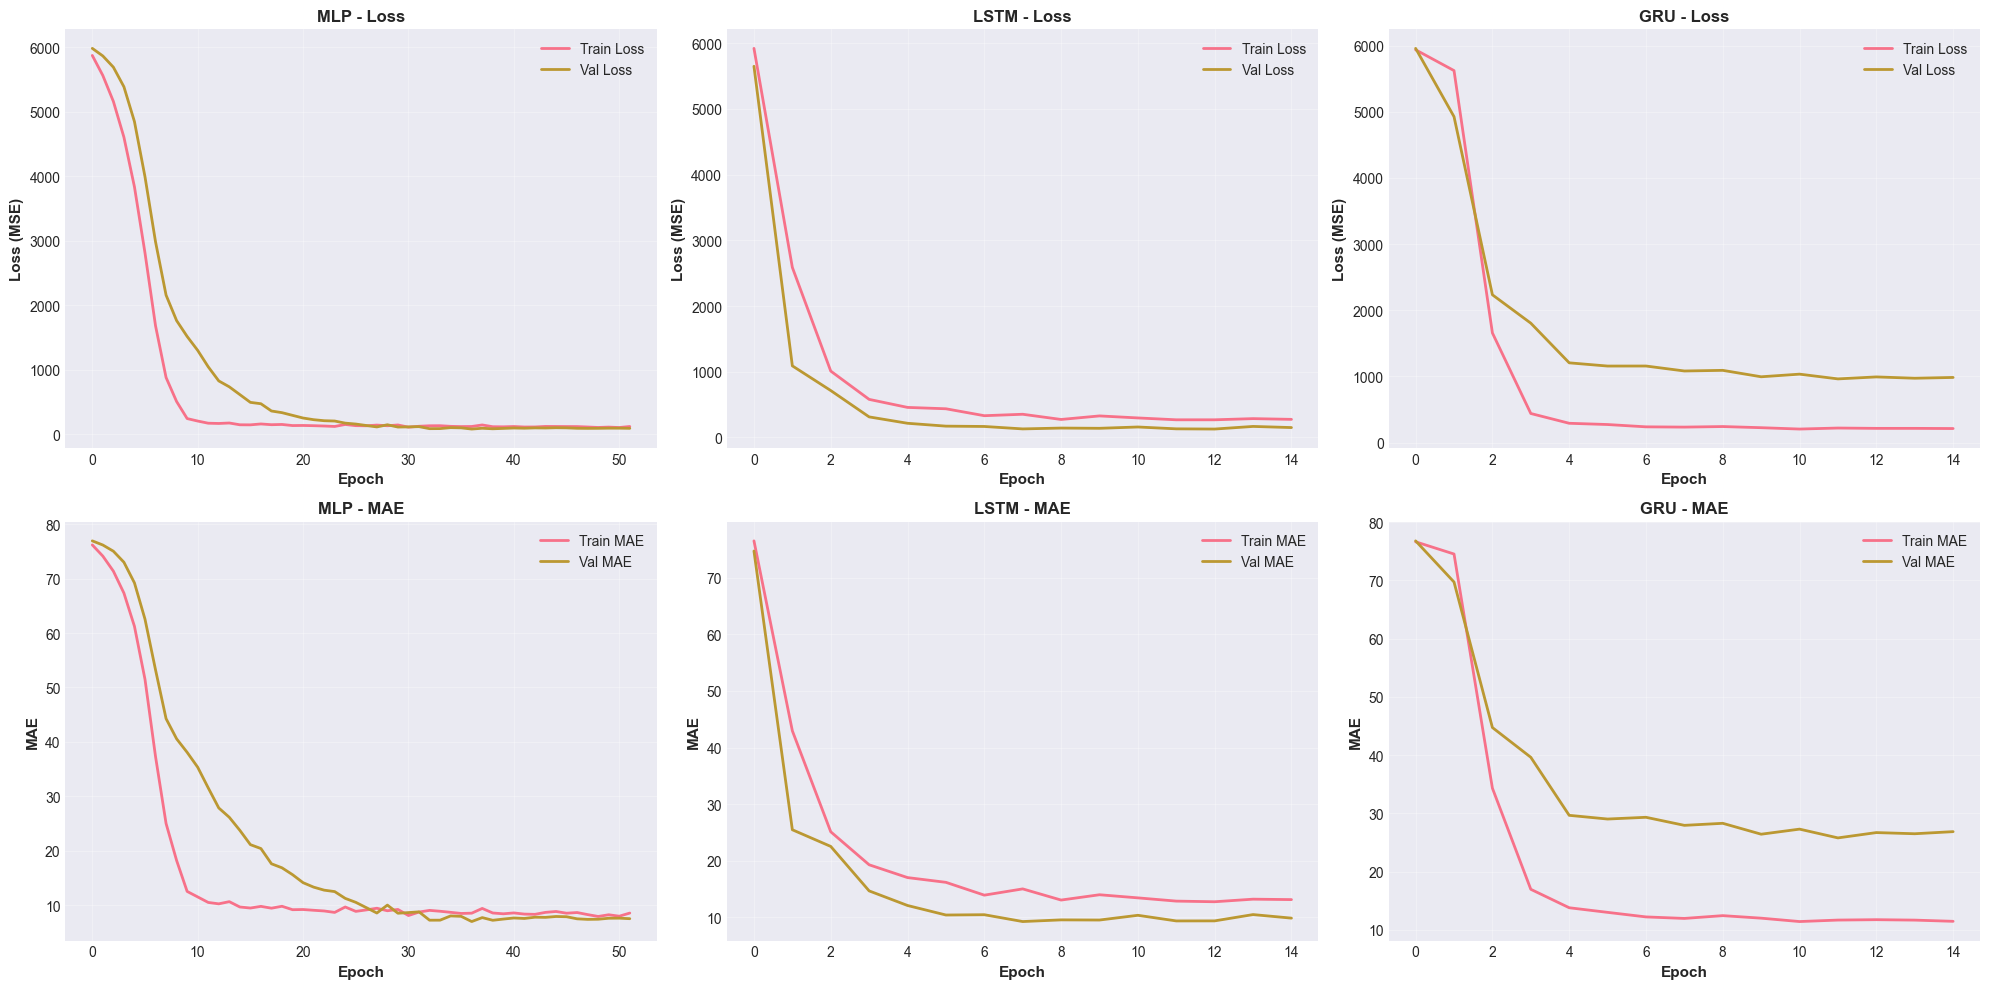

Chart saved: charts/07_deep_learning_training_history.png


In [40]:
# Plot training histories for deep learning models
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

dl_models = [('MLP', mlp_history), ('LSTM', lstm_history), ('GRU', gru_history)]

for idx, (name, history) in enumerate(dl_models):
    # Loss
    ax = axes[0, idx]
    ax.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax.set_ylabel('Loss (MSE)', fontsize=11, fontweight='bold')
    ax.set_title(f'{name} - Loss', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # MAE
    ax = axes[1, idx]
    ax.plot(history.history['mae'], label='Train MAE', linewidth=2)
    ax.plot(history.history['val_mae'], label='Val MAE', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax.set_ylabel('MAE', fontsize=11, fontweight='bold')
    ax.set_title(f'{name} - MAE', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('charts/07_deep_learning_training_history.png', dpi=300, bbox_inches='tight')
plt.show()
print("Chart saved: charts/07_deep_learning_training_history.png")

### 5.7 Time Series - Prophet

In [41]:
# Prepare data for Prophet
prophet_train = pd.DataFrame({
    'ds': df_train['Timestamp'],
    'y': df_train['EnergyConsumption'],
    'temperature': df_train['Temperature'],
    'humidity': df_train['Humidity'],
    'occupancy': df_train['Occupancy']
})

prophet_test = pd.DataFrame({
    'ds': df_test['Timestamp'],
    'temperature': df_test['Temperature'],
    'humidity': df_test['Humidity'],
    'occupancy': df_test['Occupancy']
})

print(f"Prophet train shape: {prophet_train.shape}")
print(f"Prophet test shape: {prophet_test.shape}")

Prophet train shape: (800, 5)
Prophet test shape: (200, 4)


In [42]:
# Train Prophet
print("Training Prophet...")
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='additive'
)

prophet_model.add_regressor('temperature')
prophet_model.add_regressor('humidity')
prophet_model.add_regressor('occupancy')

prophet_model.fit(prophet_train)

prophet_forecast = prophet_model.predict(prophet_test)
prophet_pred = prophet_forecast['yhat'].values

models_results['Prophet'] = evaluate_model('Prophet', y_test, prophet_pred)
models_results['Prophet']['predictions'] = prophet_pred

23:24:21 - cmdstanpy - INFO - Chain [1] start processing
23:24:21 - cmdstanpy - INFO - Chain [1] done processing


Training Prophet...

Prophet Results:
  RMSE: 5.5328
  MAE:  4.4976
  R²:   0.5005
  MAPE: 5.94%


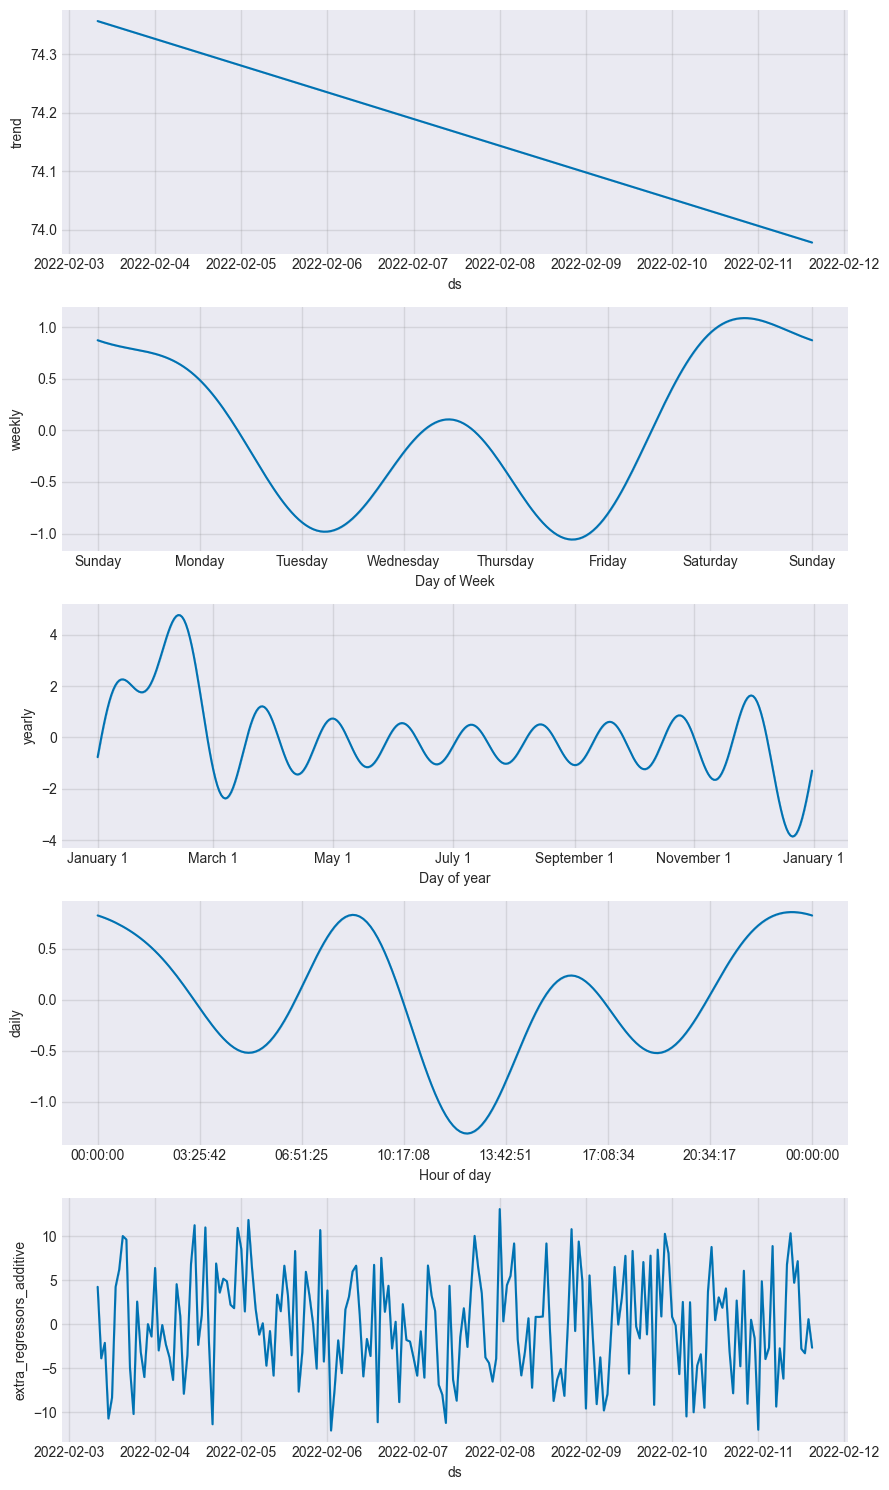

Chart saved: charts/08_prophet_components.png


In [43]:
# Plot Prophet components
fig = prophet_model.plot_components(prophet_forecast)
plt.tight_layout()
plt.savefig('charts/08_prophet_components.png', dpi=300, bbox_inches='tight')
plt.show()
print("Chart saved: charts/08_prophet_components.png")

### 5.8 Ensemble Methods

In [44]:
# Voting Regressor (ensemble of best models)
print("Training Voting Regressor...")
voting_model = VotingRegressor([
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)),
    ('xgb', xgb.XGBRegressor(n_estimators=100, max_depth=8, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42))
])

voting_model.fit(X_train_scaled, y_train)
voting_pred = voting_model.predict(X_test_scaled)
models_results['Voting Regressor'] = evaluate_model('Voting Regressor', y_test, voting_pred)
models_results['Voting Regressor']['predictions'] = voting_pred

Training Voting Regressor...

Voting Regressor Results:
  RMSE: 5.1812
  MAE:  4.1834
  R²:   0.5619
  MAPE: 5.42%


In [45]:
# Stacking Regressor
print("Training Stacking Regressor...")
stacking_model = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(n_estimators=50, max_depth=15, random_state=42, n_jobs=-1)),
        ('xgb', xgb.XGBRegressor(n_estimators=50, max_depth=6, random_state=42)),
        ('gb', GradientBoostingRegressor(n_estimators=50, max_depth=4, random_state=42))
    ],
    final_estimator=Ridge(alpha=1.0)
)

stacking_model.fit(X_train_scaled, y_train)
stacking_pred = stacking_model.predict(X_test_scaled)
models_results['Stacking Regressor'] = evaluate_model('Stacking Regressor', y_test, stacking_pred)
models_results['Stacking Regressor']['predictions'] = stacking_pred

Training Stacking Regressor...

Stacking Regressor Results:
  RMSE: 4.9967
  MAE:  4.1087
  R²:   0.5926
  MAPE: 5.33%


## 6. Feature Importance Analysis

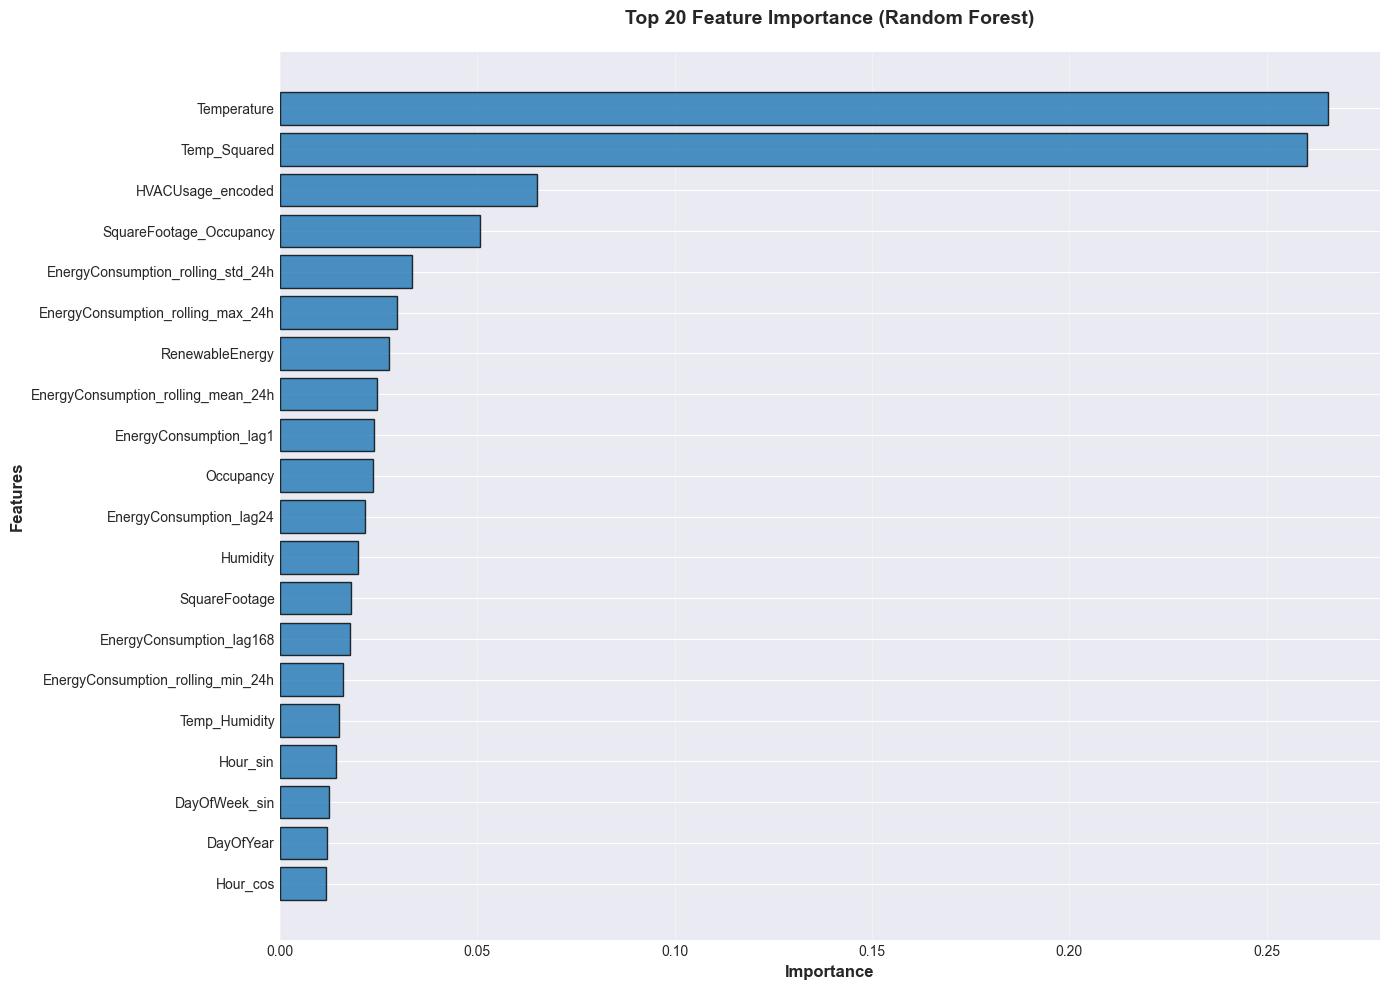

Chart saved: charts/09_feature_importance.png


In [46]:
# Feature importance from Random Forest
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(14, 10))
plt.barh(feature_importance_df['feature'][:20], feature_importance_df['importance'][:20], 
         color='#1F77B4', alpha=0.8, edgecolor='black')
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title('Top 20 Feature Importance (Random Forest)', fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('charts/09_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("Chart saved: charts/09_feature_importance.png")

## 7. Model Comparison and Visualization

In [47]:
# Create comparison dataframe
comparison_data = []
for model_name, results in models_results.items():
    comparison_data.append({
        'Model': model_name,
        'RMSE': results['RMSE'],
        'MAE': results['MAE'],
        'R2': results['R2'],
        'MAPE': results['MAPE'],
        'EVS': results['EVS']
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('RMSE')

print("\n" + "="*100)
print("MODEL COMPARISON (Sorted by RMSE)")
print("="*100)
print(comparison_df.to_string(index=False))
print("\n" + "="*100)


MODEL COMPARISON (Sorted by RMSE)
             Model      RMSE       MAE         R2      MAPE       EVS
          AdaBoost  4.834020  3.937991   0.618680  5.118771  0.624569
        ElasticNet  4.901960  4.003399   0.607886  5.247396  0.608064
             Lasso  4.926483  4.041407   0.603953  5.271316  0.605377
    Bayesian Ridge  4.940510  4.006203   0.601695  5.276348  0.606057
      SVR (Linear)  4.956290  4.072297   0.599146  5.326799  0.599188
          CatBoost  4.968670  4.006701   0.597141  5.213436  0.599956
             Ridge  4.974769  4.034017   0.596152  5.311768  0.600406
 Linear Regression  4.990580  4.044969   0.593581  5.324490  0.597422
Stacking Regressor  4.996655  4.108720   0.592590  5.329492  0.598980
          LightGBM  5.056236  4.127222   0.582816  5.369659  0.588665
     Random Forest  5.108323  4.175884   0.574177  5.412317  0.581939
  Voting Regressor  5.181206  4.183379   0.561939  5.424098  0.568293
 Gradient Boosting  5.257371  4.236026   0.548965  5.49

In [48]:
# Save comparison results to CSV
comparison_df.to_csv('model_comparison_results.csv', index=False)
print("Model comparison saved to: model_comparison_results.csv")

Model comparison saved to: model_comparison_results.csv


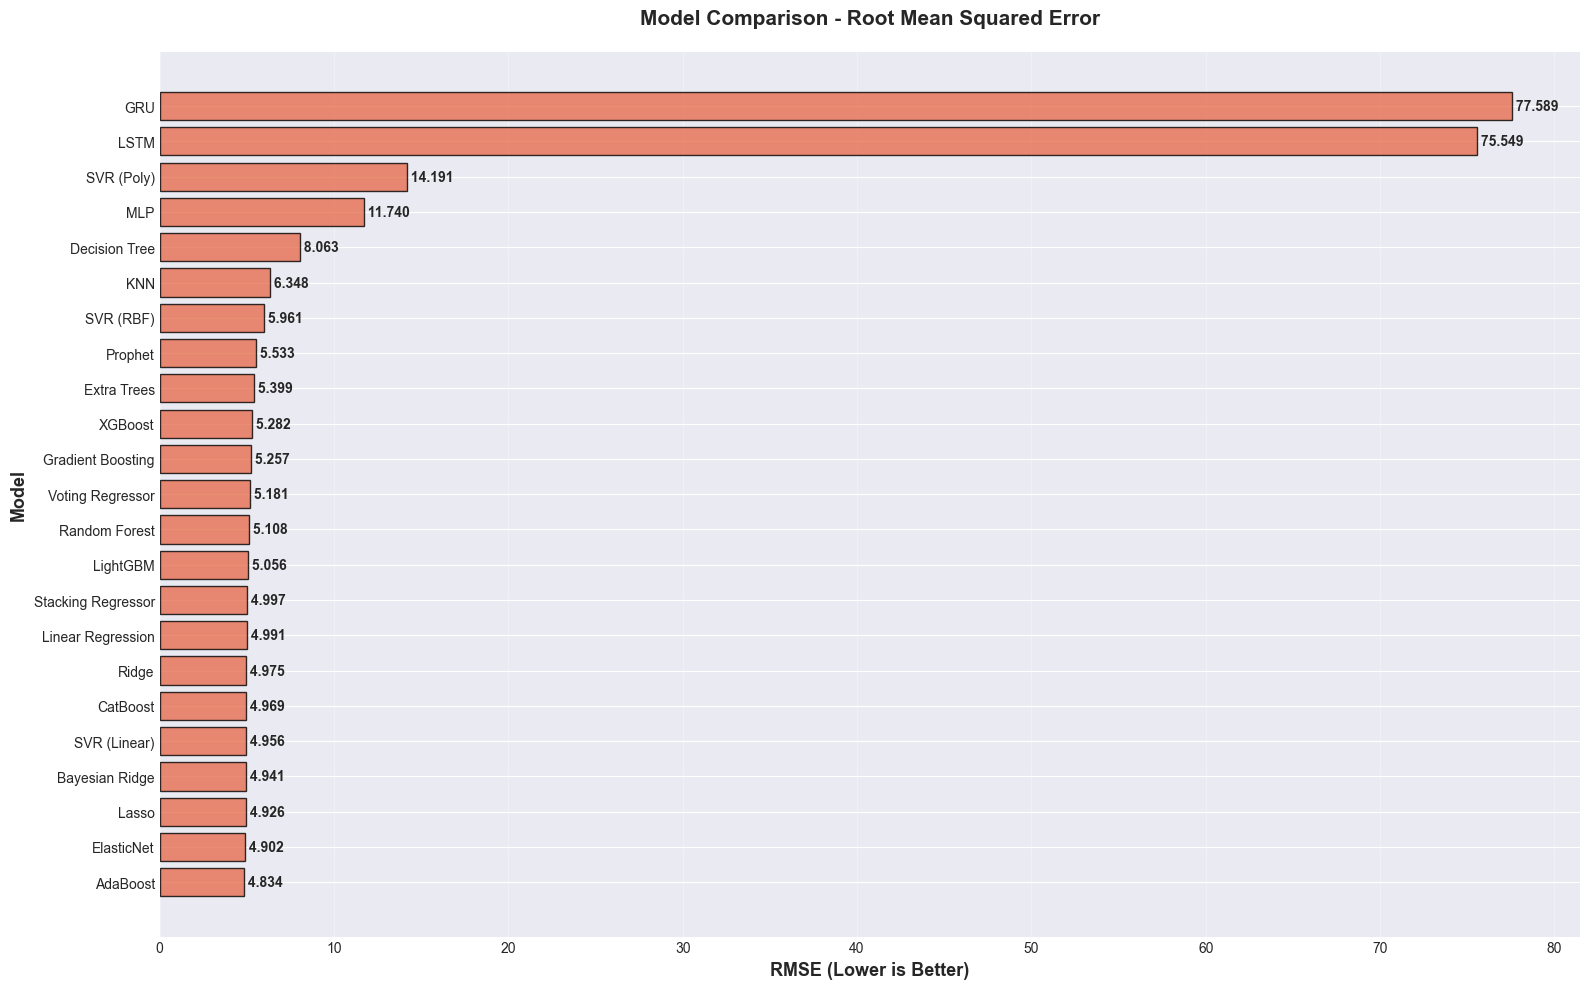

Chart saved: charts/10_model_comparison_rmse.png


In [49]:
# RMSE Comparison Chart
fig, ax = plt.subplots(figsize=(16, 10))
bars = ax.barh(comparison_df['Model'], comparison_df['RMSE'], 
               color='#E76F51', alpha=0.8, edgecolor='black')
ax.set_xlabel('RMSE (Lower is Better)', fontsize=13, fontweight='bold')
ax.set_ylabel('Model', fontsize=13, fontweight='bold')
ax.set_title('Model Comparison - Root Mean Squared Error', fontsize=15, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')

for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f' {width:.3f}',
            ha='left', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('charts/10_model_comparison_rmse.png', dpi=300, bbox_inches='tight')
plt.show()
print("Chart saved: charts/10_model_comparison_rmse.png")

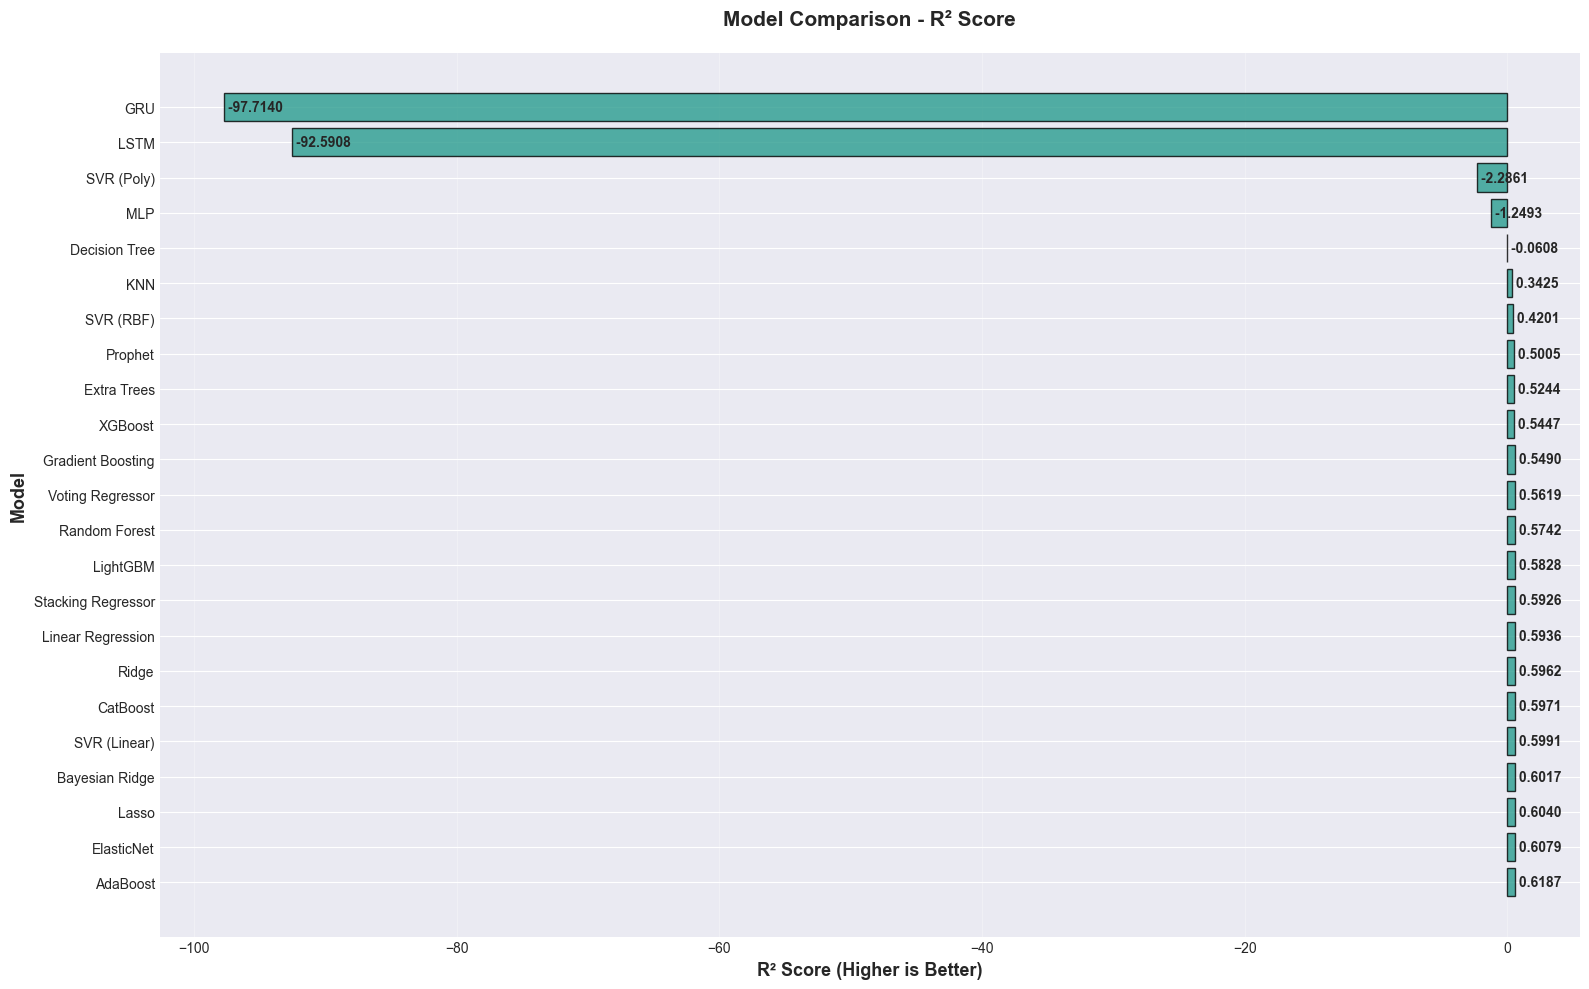

Chart saved: charts/11_model_comparison_r2.png


In [50]:
# R² Comparison Chart
comparison_df_r2 = comparison_df.sort_values('R2', ascending=False)
fig, ax = plt.subplots(figsize=(16, 10))
bars = ax.barh(comparison_df_r2['Model'], comparison_df_r2['R2'], 
               color='#2A9D8F', alpha=0.8, edgecolor='black')
ax.set_xlabel('R² Score (Higher is Better)', fontsize=13, fontweight='bold')
ax.set_ylabel('Model', fontsize=13, fontweight='bold')
ax.set_title('Model Comparison - R² Score', fontsize=15, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')

for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f' {width:.4f}',
            ha='left', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('charts/11_model_comparison_r2.png', dpi=300, bbox_inches='tight')
plt.show()
print("Chart saved: charts/11_model_comparison_r2.png")

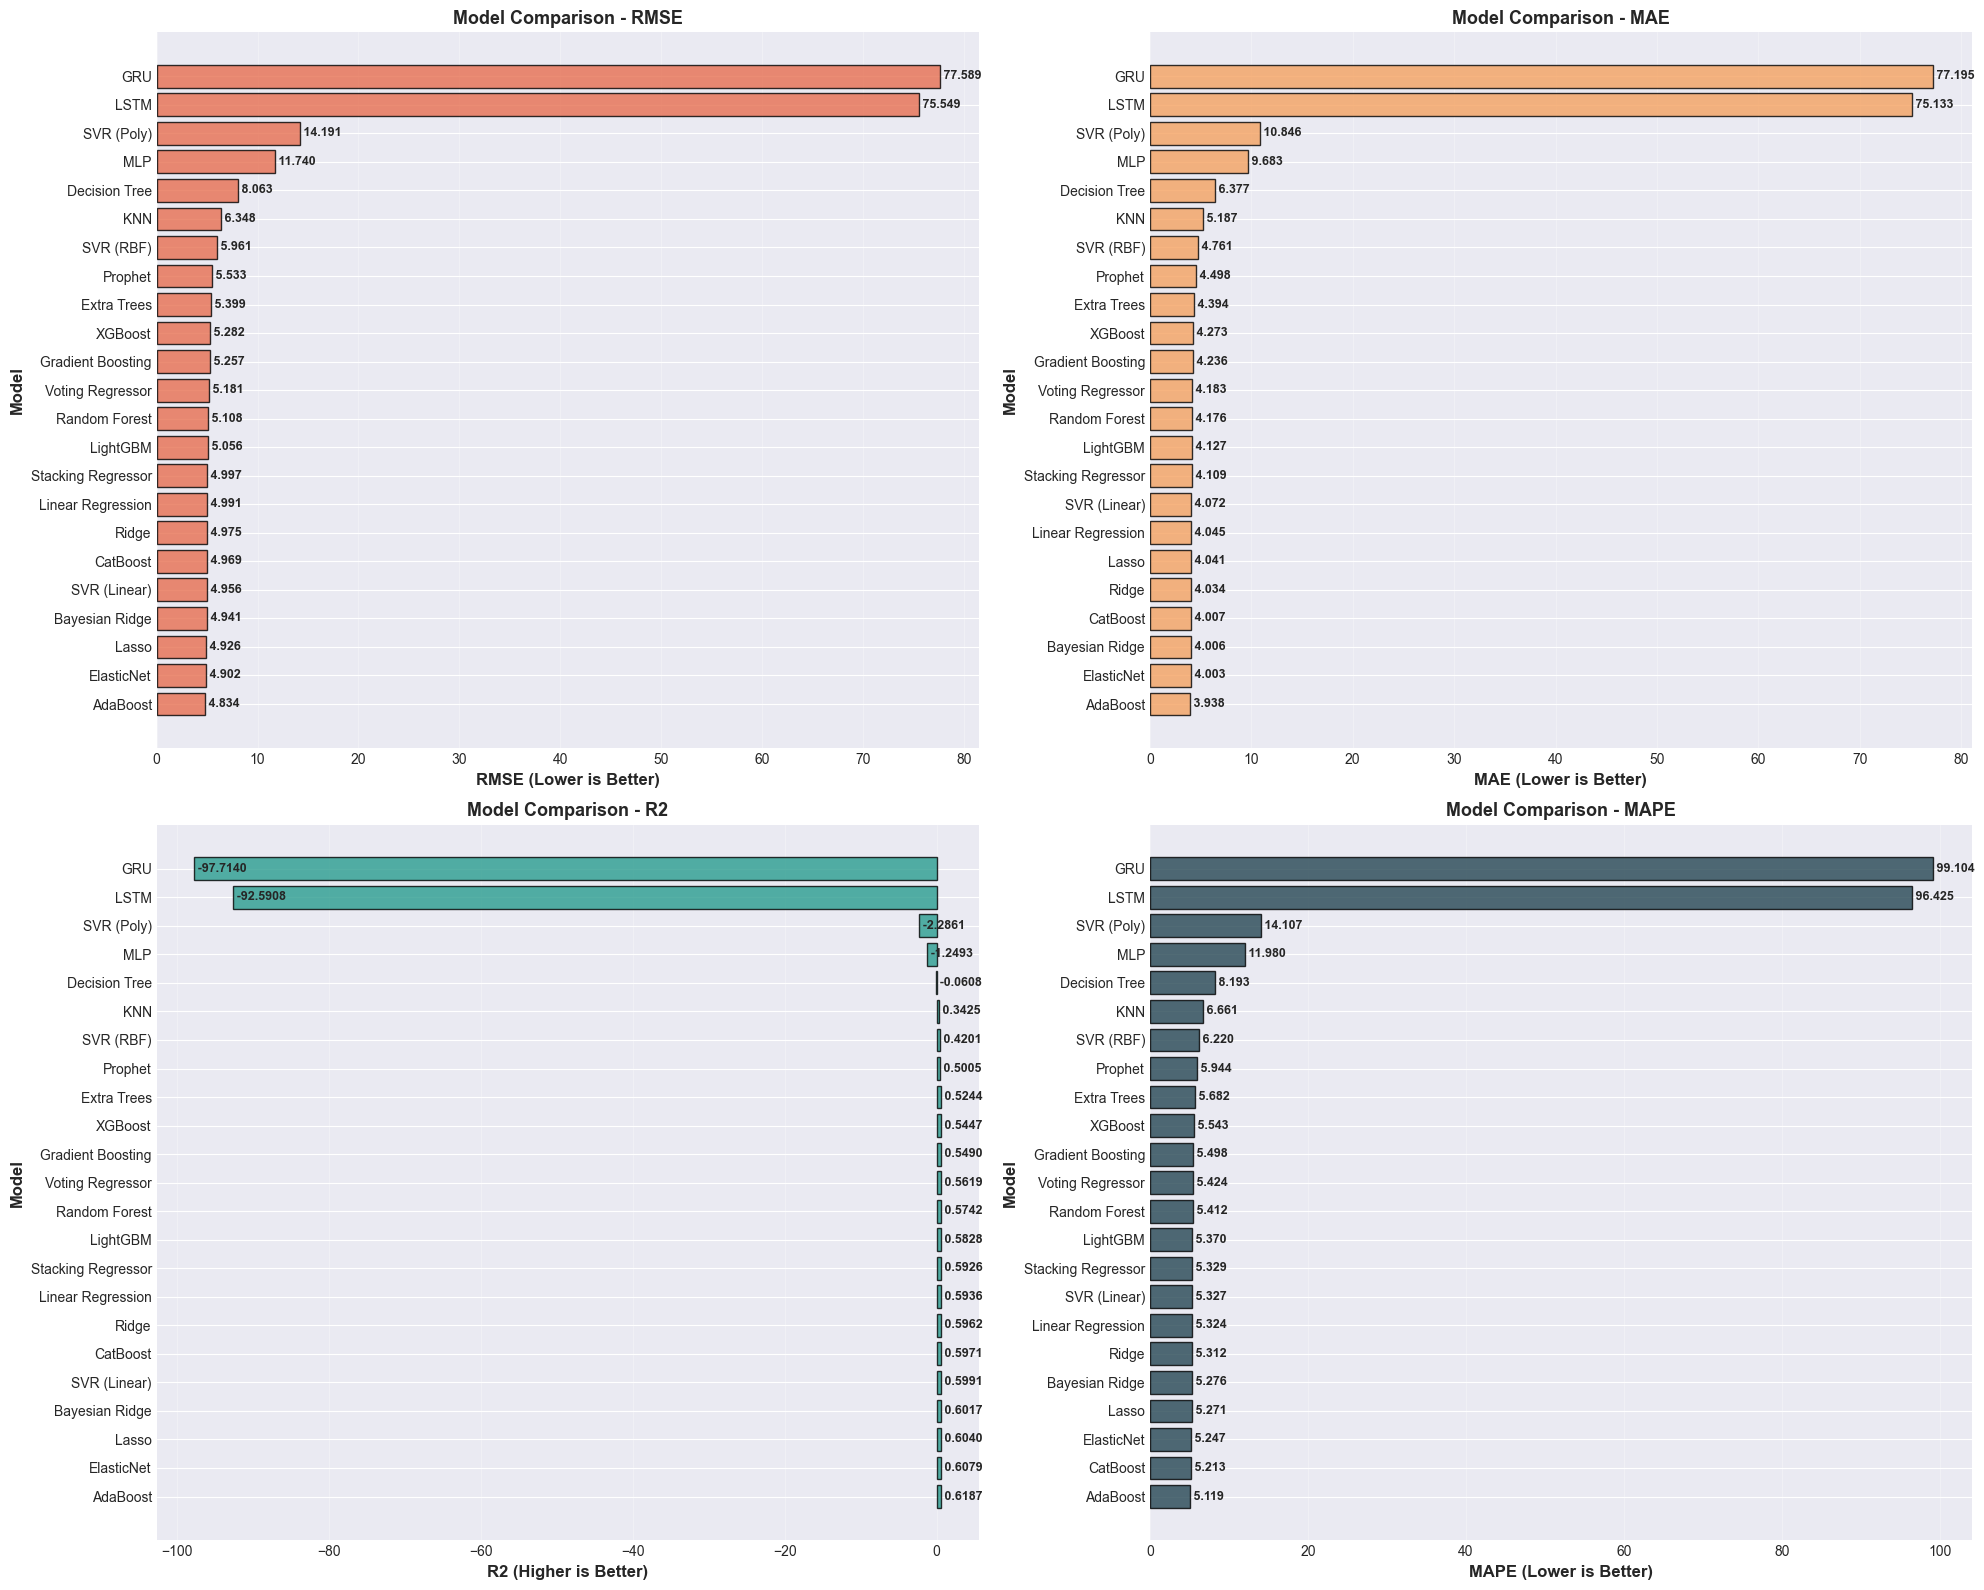

Chart saved: charts/12_model_comparison_all_metrics.png


In [51]:
# Multi-metric comparison
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
metrics_to_plot = ['RMSE', 'MAE', 'R2', 'MAPE']
colors = ['#E76F51', '#F4A261', '#2A9D8F', '#264653']
titles = ['Lower is Better', 'Lower is Better', 'Higher is Better', 'Lower is Better']

for idx, (metric, color, title) in enumerate(zip(metrics_to_plot, colors, titles)):
    ax = axes[idx // 2, idx % 2]
    
    if metric == 'R2':
        sorted_df = comparison_df.sort_values(metric, ascending=False)
    else:
        sorted_df = comparison_df.sort_values(metric)
    
    bars = ax.barh(sorted_df['Model'], sorted_df[metric], color=color, alpha=0.8, edgecolor='black')
    ax.set_xlabel(f'{metric} ({title})', fontsize=12, fontweight='bold')
    ax.set_ylabel('Model', fontsize=12, fontweight='bold')
    ax.set_title(f'Model Comparison - {metric}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    for bar in bars:
        width = bar.get_width()
        format_str = '.4f' if metric == 'R2' else '.3f'
        ax.text(width, bar.get_y() + bar.get_height()/2, f' {width:{format_str}}',
                ha='left', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('charts/12_model_comparison_all_metrics.png', dpi=300, bbox_inches='tight')
plt.show()
print("Chart saved: charts/12_model_comparison_all_metrics.png")

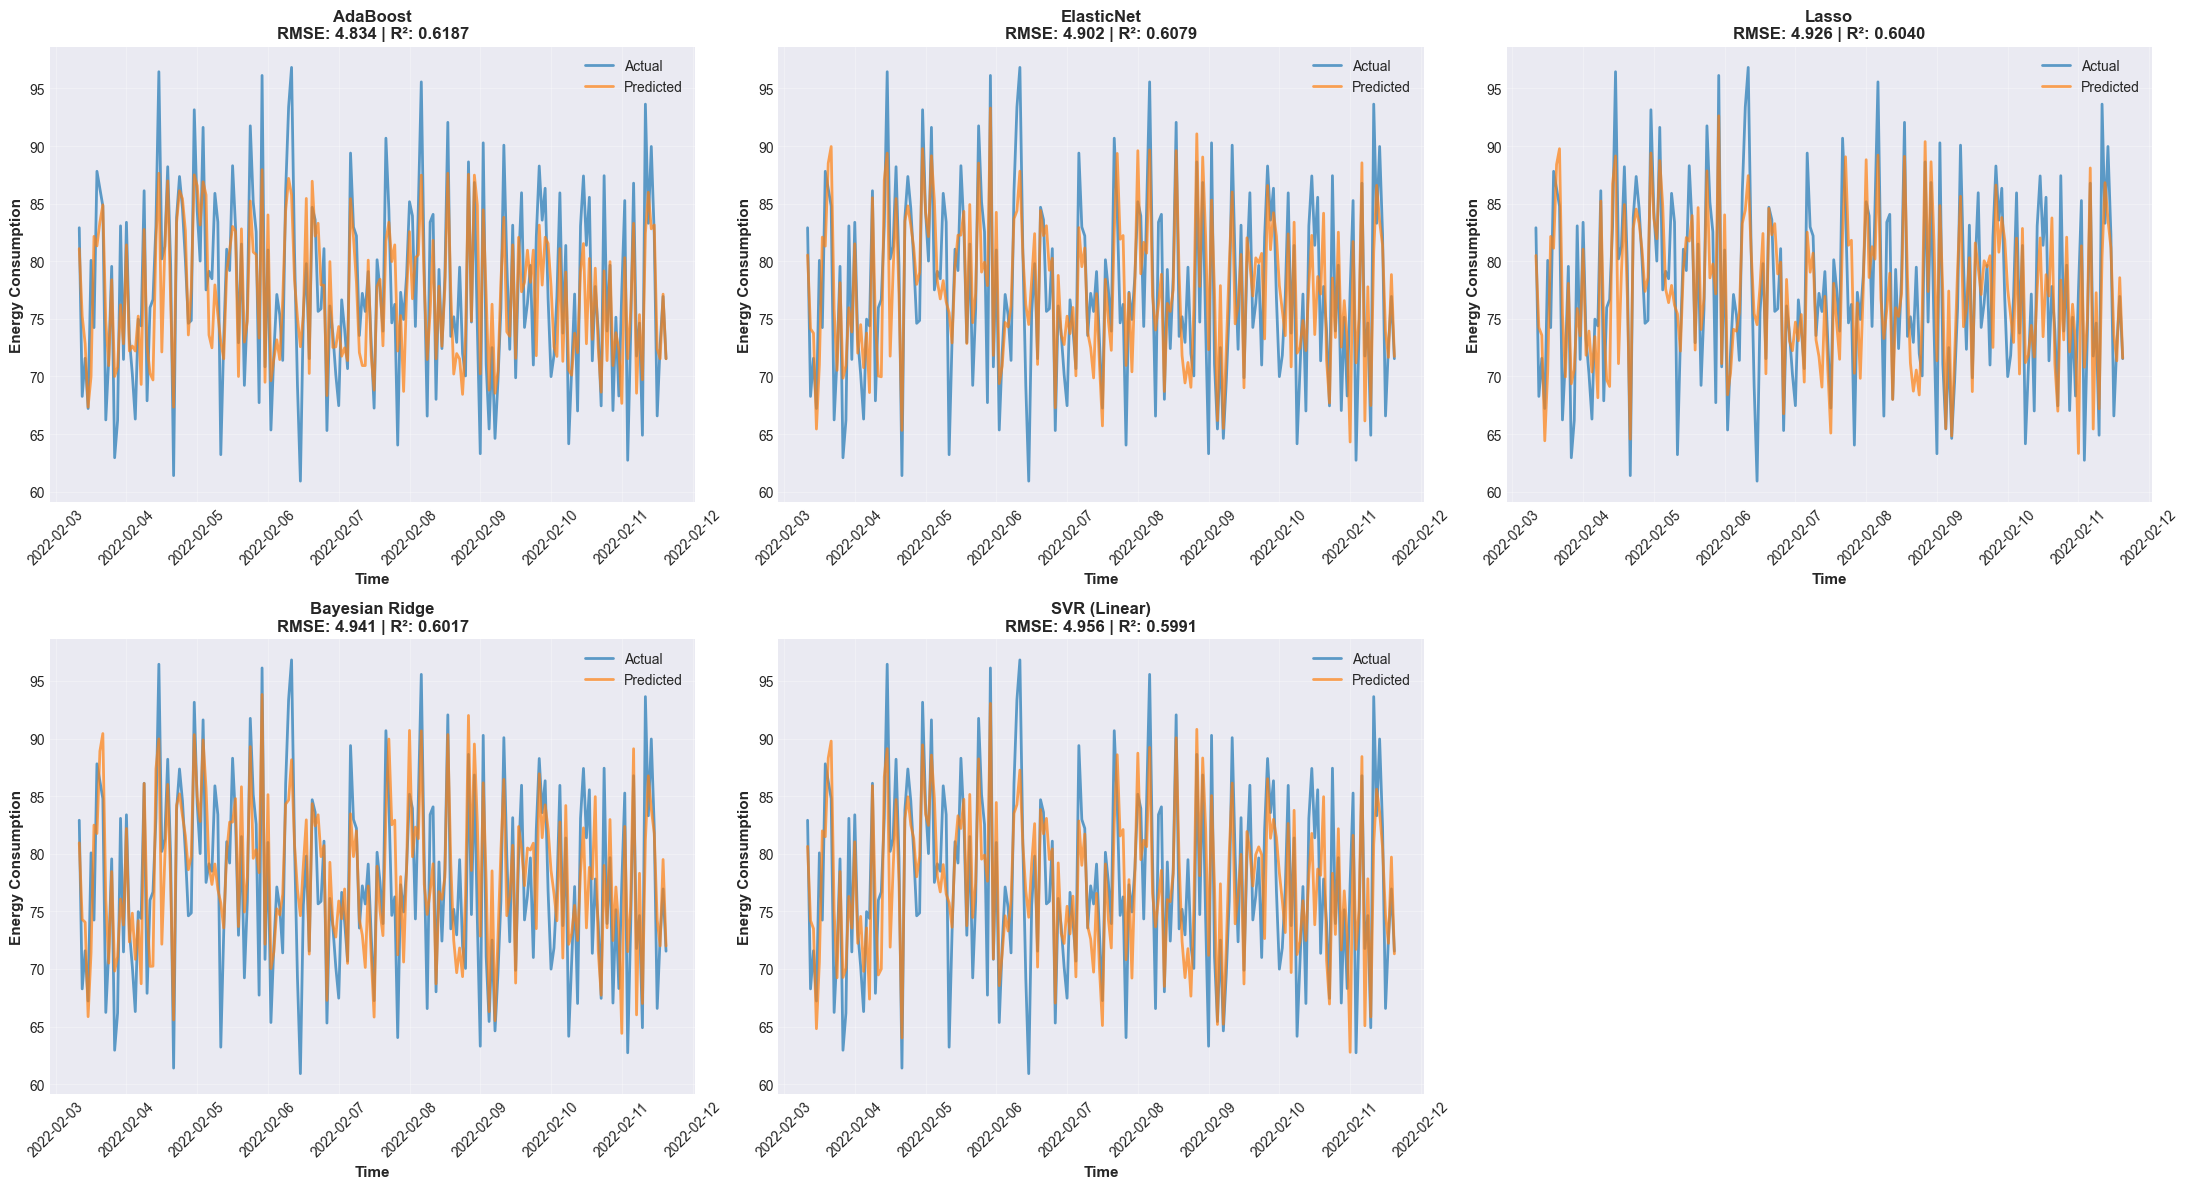

Chart saved: charts/13_top5_models_predictions.png


In [52]:
# Top 5 Models - Predictions vs Actual
top_5_models = comparison_df.head(5)['Model'].tolist()
fig, axes = plt.subplots(2, 3, figsize=(22, 12))
axes = axes.flatten()

for idx, model_name in enumerate(top_5_models):
    ax = axes[idx]
    
    if model_name in ['LSTM', 'GRU']:
        actual = y_test_lstm
        timestamps = df_test['Timestamp'].values[time_steps:]
    else:
        actual = y_test
        timestamps = df_test['Timestamp'].values
    
    pred = models_results[model_name]['predictions']
    
    plot_points = min(500, len(actual))
    ax.plot(timestamps[:plot_points], actual[:plot_points], 
            label='Actual', linewidth=2, alpha=0.7, color='#1f77b4')
    ax.plot(timestamps[:plot_points], pred[:plot_points], 
            label='Predicted', linewidth=2, alpha=0.7, color='#ff7f0e')
    
    ax.set_xlabel('Time', fontsize=11, fontweight='bold')
    ax.set_ylabel('Energy Consumption', fontsize=11, fontweight='bold')
    ax.set_title(f'{model_name}\nRMSE: {models_results[model_name]["RMSE"]:.3f} | R²: {models_results[model_name]["R2"]:.4f}', 
                 fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

axes[5].set_visible(False)

plt.tight_layout()
plt.savefig('charts/13_top5_models_predictions.png', dpi=300, bbox_inches='tight')
plt.show()
print("Chart saved: charts/13_top5_models_predictions.png")

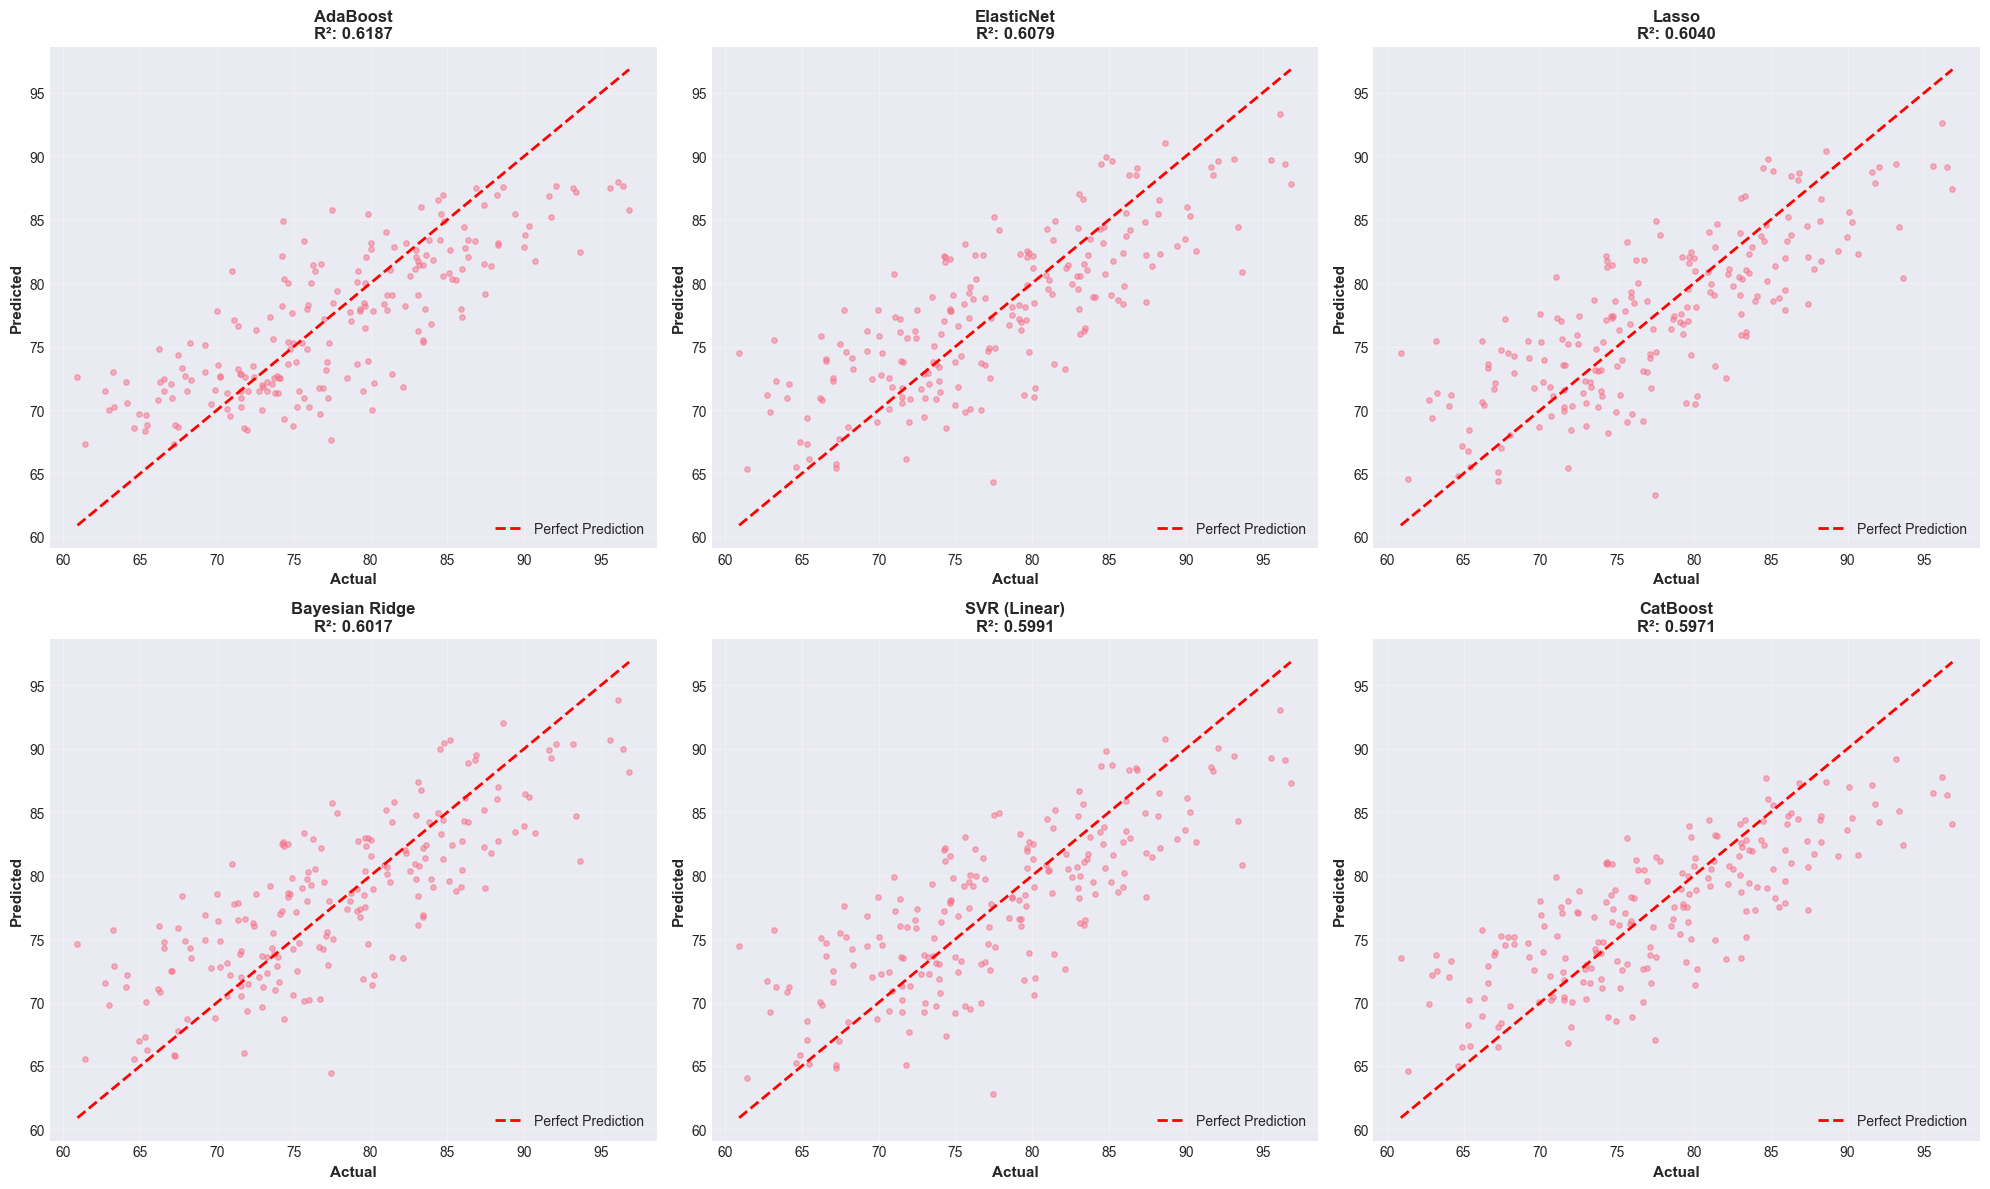

Chart saved: charts/14_scatter_predictions_vs_actual.png


In [53]:
# Scatter plots - Predicted vs Actual (Top 6 models)
top_6_models = comparison_df.head(6)['Model'].tolist()
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, model_name in enumerate(top_6_models):
    ax = axes[idx]
    
    if model_name in ['LSTM', 'GRU']:
        actual = y_test_lstm
    else:
        actual = y_test
    
    pred = models_results[model_name]['predictions']
    
    ax.scatter(actual, pred, alpha=0.5, s=15)
    
    min_val = min(actual.min(), pred.min())
    max_val = max(actual.max(), pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    ax.set_xlabel('Actual', fontsize=11, fontweight='bold')
    ax.set_ylabel('Predicted', fontsize=11, fontweight='bold')
    ax.set_title(f'{model_name}\nR²: {models_results[model_name]["R2"]:.4f}', 
                 fontsize=12, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('charts/14_scatter_predictions_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()
print("Chart saved: charts/14_scatter_predictions_vs_actual.png")

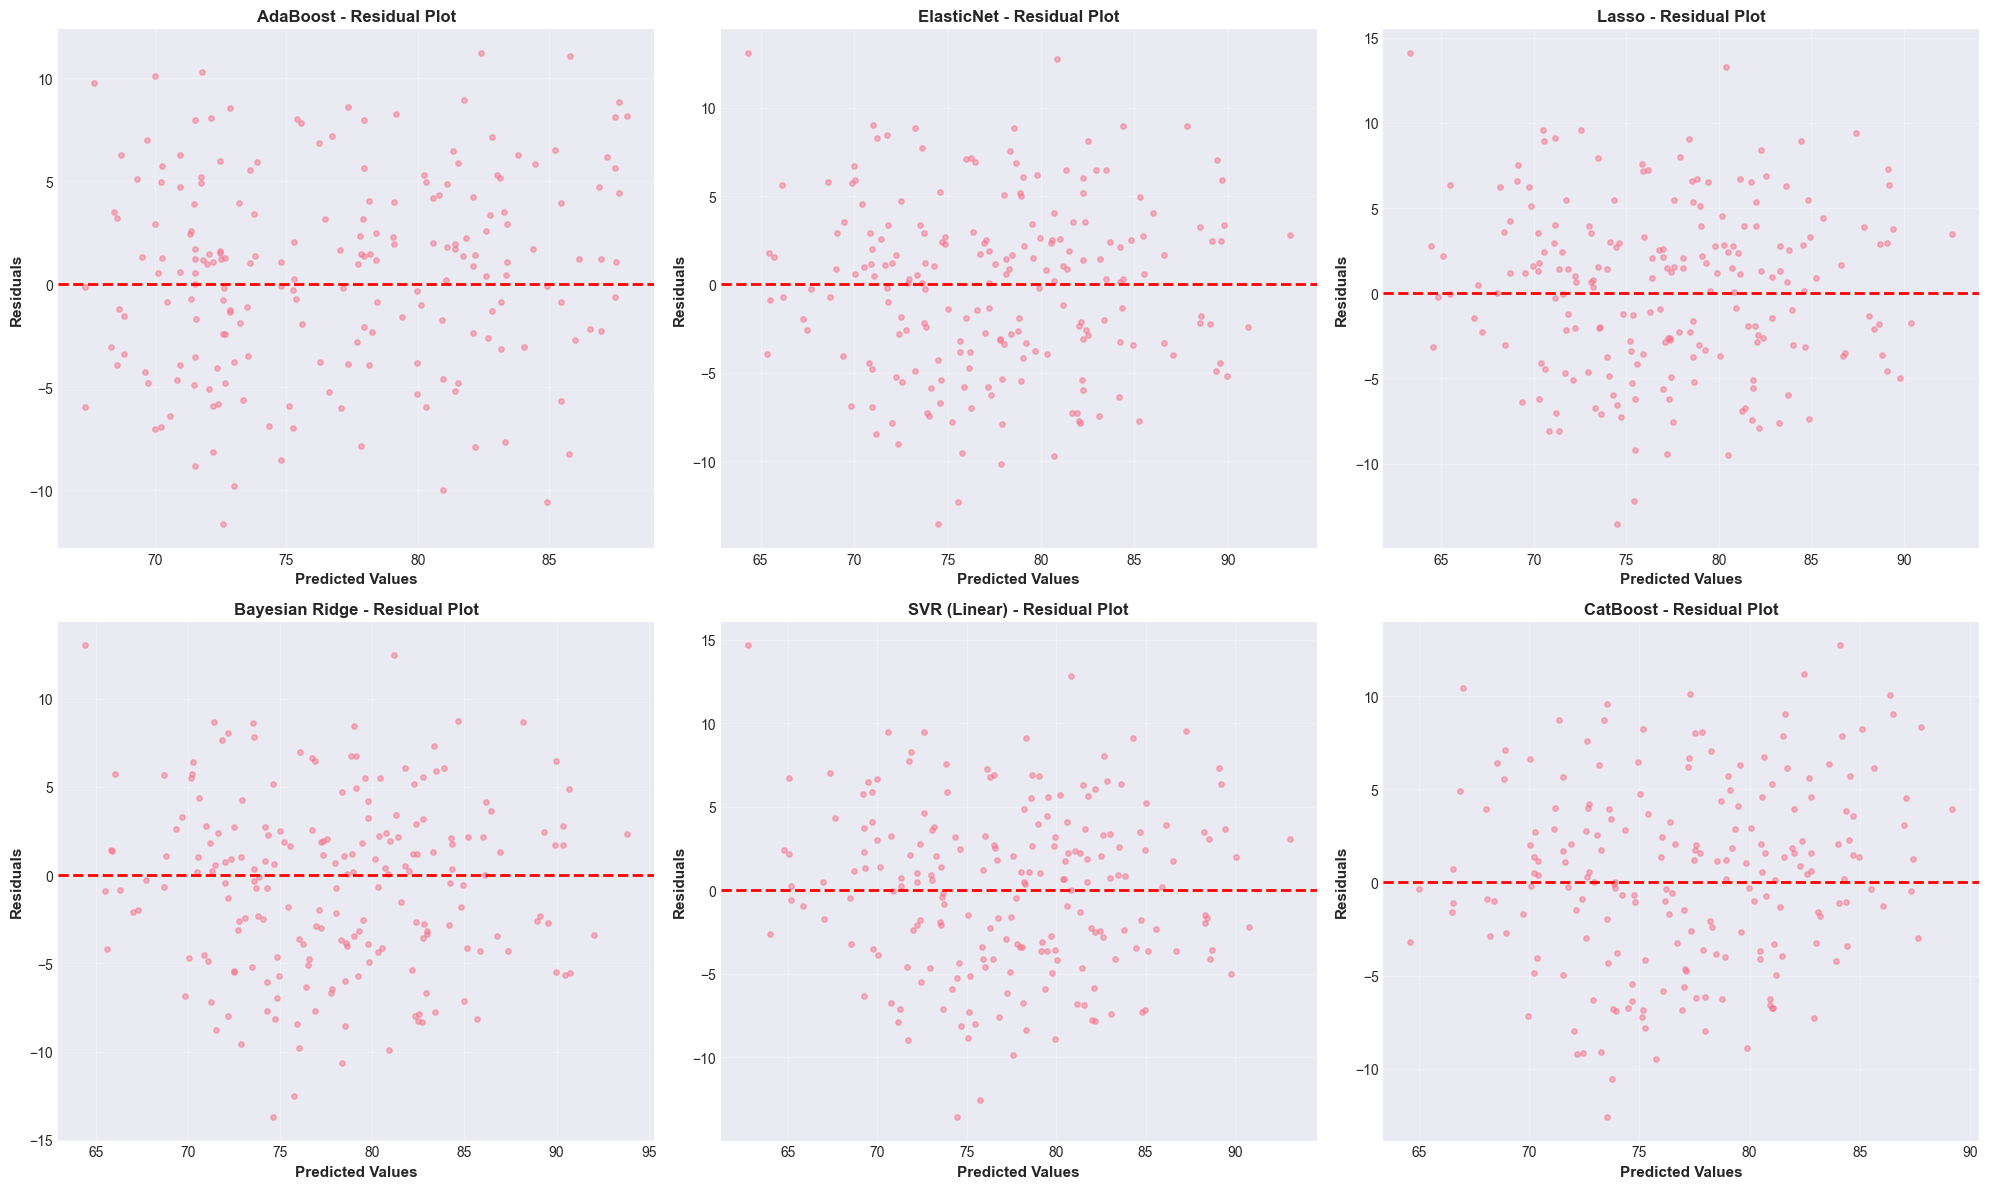

Chart saved: charts/15_residual_plots.png


In [54]:
# Residual plots for top 6 models
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, model_name in enumerate(top_6_models):
    ax = axes[idx]
    
    if model_name in ['LSTM', 'GRU']:
        actual = y_test_lstm
    else:
        actual = y_test
    
    pred = models_results[model_name]['predictions']
    residuals = actual - pred
    
    ax.scatter(pred, residuals, alpha=0.5, s=15)
    ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax.set_xlabel('Predicted Values', fontsize=11, fontweight='bold')
    ax.set_ylabel('Residuals', fontsize=11, fontweight='bold')
    ax.set_title(f'{model_name} - Residual Plot', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('charts/15_residual_plots.png', dpi=300, bbox_inches='tight')
plt.show()
print("Chart saved: charts/15_residual_plots.png")

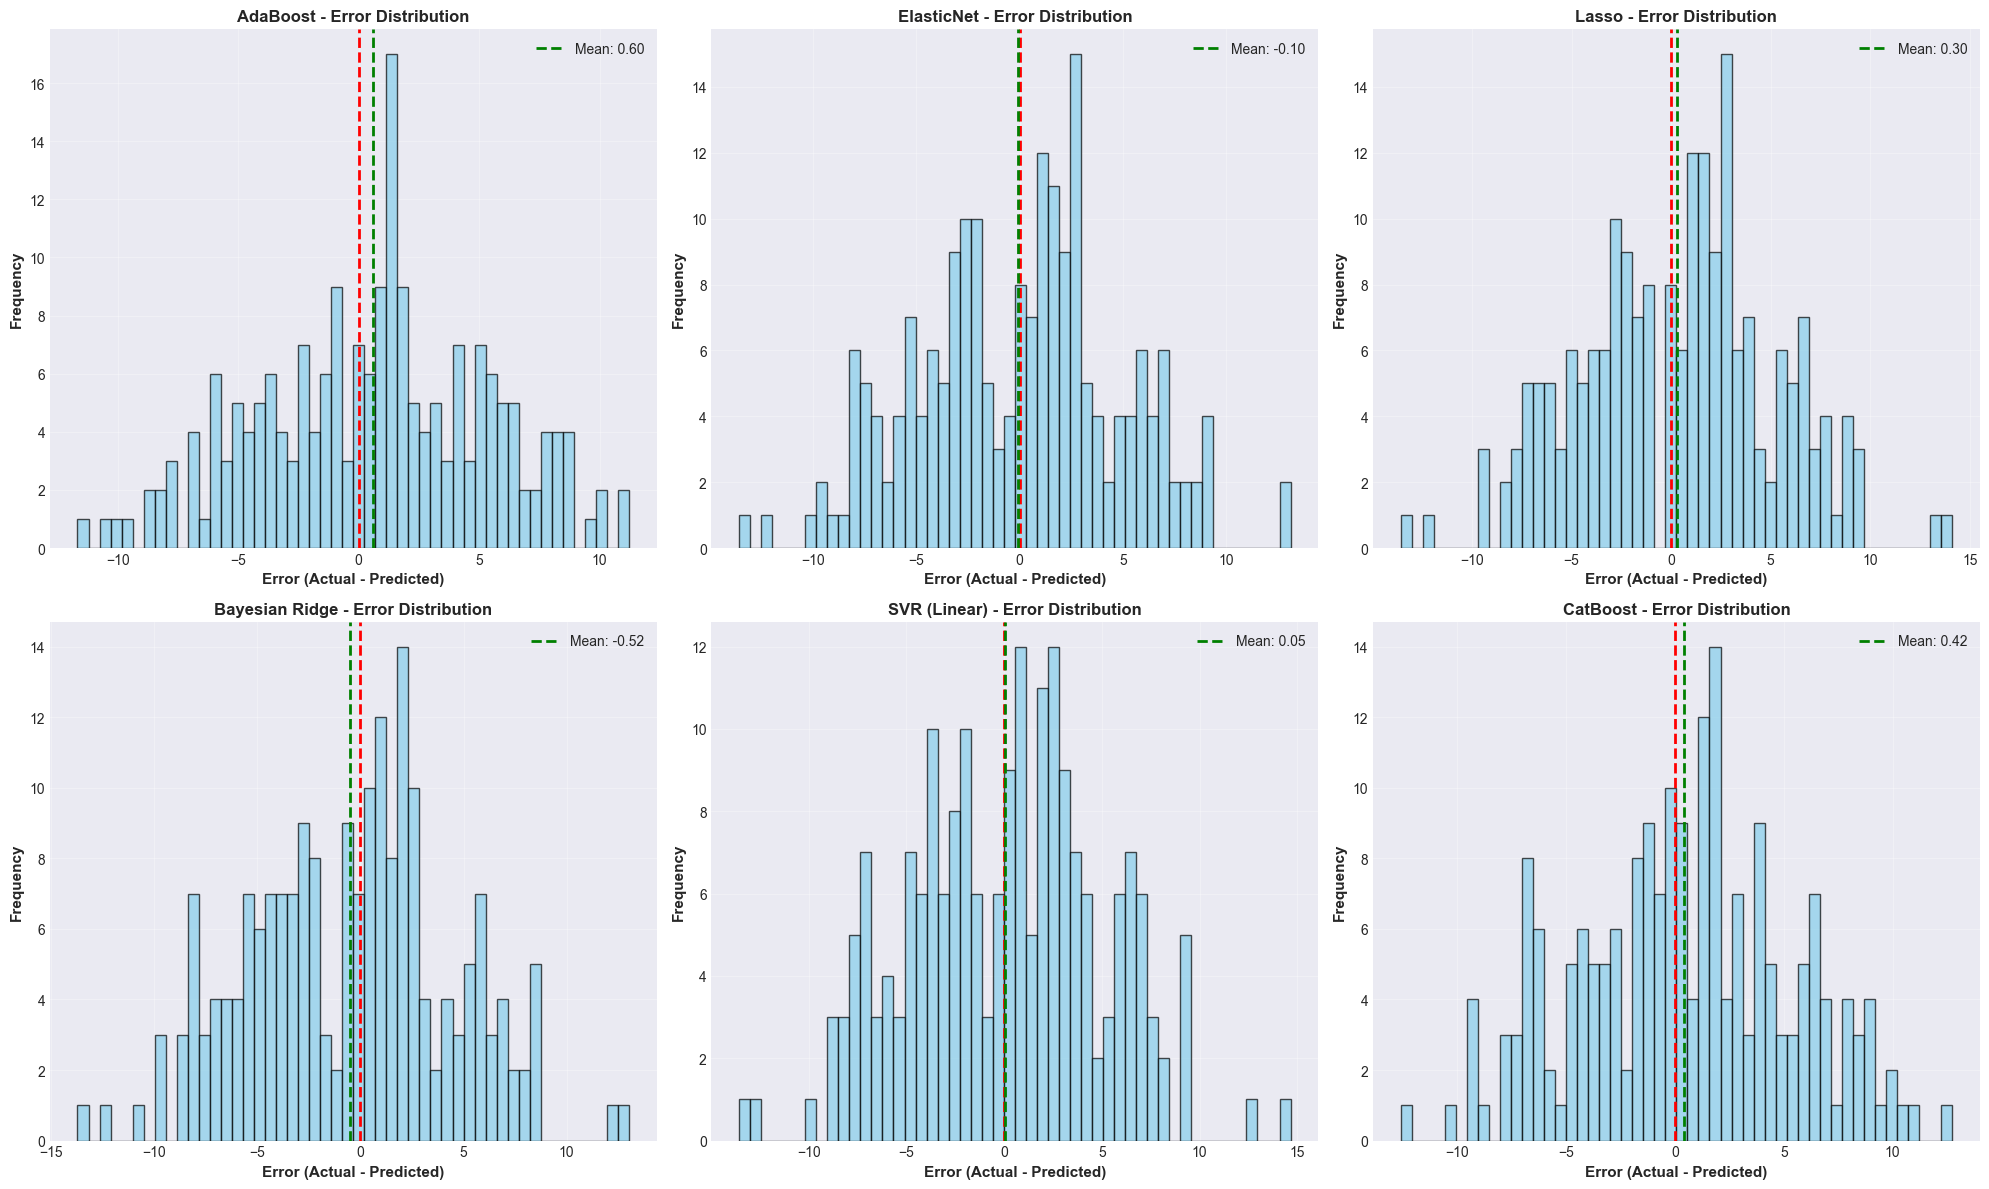

Chart saved: charts/16_error_distribution.png


In [55]:
# Error distribution for top 6 models
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, model_name in enumerate(top_6_models):
    ax = axes[idx]
    
    if model_name in ['LSTM', 'GRU']:
        actual = y_test_lstm
    else:
        actual = y_test
    
    pred = models_results[model_name]['predictions']
    errors = actual - pred
    
    ax.hist(errors, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    ax.axvline(x=0, color='r', linestyle='--', linewidth=2)
    ax.axvline(x=errors.mean(), color='g', linestyle='--', linewidth=2, label=f'Mean: {errors.mean():.2f}')
    ax.set_xlabel('Error (Actual - Predicted)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title(f'{model_name} - Error Distribution', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('charts/16_error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Chart saved: charts/16_error_distribution.png")

## 8. Final Summary and Recommendations

In [56]:
# Comprehensive Summary
print("\n" + "="*100)
print("ENERGY CONSUMPTION PREDICTION - COMPREHENSIVE ANALYSIS SUMMARY")
print("="*100)

print(f"\nDataset Information:")
print(f"  Total Samples: {len(df):,}")
print(f"  Training Samples: {len(X_train):,}")
print(f"  Test Samples: {len(X_test):,}")
print(f"  Features Used: {len(feature_cols)}")
print(f"  Date Range: {df['Timestamp'].min()} to {df['Timestamp'].max()}")

print(f"\nModels Trained: {len(models_results)}")
print(f"  Linear Models: 5 (Linear, Ridge, Lasso, ElasticNet, Bayesian Ridge)")
print(f"  Tree Models: 6 (Decision Tree, Random Forest, Extra Trees, Gradient Boosting, AdaBoost, Bagging)")
print(f"  Boosting Models: 1-3 (XGBoost + LightGBM/CatBoost if available)")
print(f"  SVM Models: 3 (SVR with RBF, Linear, Poly kernels)")
print(f"  Neighbor Models: 1 (KNN)")
print(f"  Deep Learning: 3 (MLP, LSTM, GRU)")
print(f"  Time Series: 1 (Prophet)")
print(f"  Ensemble: 2 (Voting, Stacking)")

best_model = comparison_df.iloc[0]['Model']
best_rmse = comparison_df.iloc[0]['RMSE']
best_r2 = comparison_df.iloc[0]['R2']

print(f"\n" + "="*100)
print(f"BEST PERFORMING MODEL: {best_model}")
print("="*100)
print(f"  RMSE: {best_rmse:.4f}")
print(f"  MAE:  {comparison_df.iloc[0]['MAE']:.4f}")
print(f"  R²:   {best_r2:.4f}")
print(f"  MAPE: {comparison_df.iloc[0]['MAPE']:.2f}%")

print(f"\n" + "="*100)
print("TOP 5 MODELS")
print("="*100)
for idx, row in comparison_df.head(5).iterrows():
    print(f"\n{idx+1}. {row['Model']}")
    print(f"   RMSE: {row['RMSE']:.4f} | MAE: {row['MAE']:.4f} | R²: {row['R2']:.4f} | MAPE: {row['MAPE']:.2f}%")

print(f"\n" + "="*100)
print("KEY INSIGHTS")
print("="*100)
print(f"\n1. Most Important Features (Top 5):")
for i, row in feature_importance_df.head(5).iterrows():
    print(f"   - {row['feature']}: {row['importance']:.4f}")

print(f"\n2. Model Performance Categories:")
excellent = comparison_df[comparison_df['R2'] >= 0.9]
good = comparison_df[(comparison_df['R2'] >= 0.8) & (comparison_df['R2'] < 0.9)]
moderate = comparison_df[comparison_df['R2'] < 0.8]
print(f"   - Excellent (R² >= 0.9): {len(excellent)} models")
print(f"   - Good (0.8 <= R² < 0.9): {len(good)} models")
print(f"   - Moderate (R² < 0.8): {len(moderate)} models")

print(f"\n3. Recommendations:")
print(f"   ✓ Deploy {best_model} for production use (best overall performance)")
print(f"   ✓ Consider ensemble of top 3 models for improved robustness")
print(f"   ✓ Monitor model drift with rolling validation")
print(f"   ✓ Retrain models periodically with new data")
print(f"   ✓ Focus on top features for feature engineering")
print(f"   ✓ Implement A/B testing for model deployment")

print(f"\n4. Visualizations:")
print(f"   ✓ All charts saved to 'charts/' folder (16 visualizations)")
print(f"   ✓ Model comparison saved to 'model_comparison_results.csv'")

print(f"\n" + "="*100)
print("ANALYSIS COMPLETE!")
print("="*100)
print("\nCheck the 'charts/' folder for all visualizations.")
print("Review 'model_comparison_results.csv' for detailed metrics.")


ENERGY CONSUMPTION PREDICTION - COMPREHENSIVE ANALYSIS SUMMARY

Dataset Information:
  Total Samples: 1,000
  Training Samples: 800
  Test Samples: 200
  Features Used: 29
  Date Range: 2022-01-01 00:00:00 to 2022-02-11 15:00:00

Models Trained: 23
  Linear Models: 5 (Linear, Ridge, Lasso, ElasticNet, Bayesian Ridge)
  Tree Models: 6 (Decision Tree, Random Forest, Extra Trees, Gradient Boosting, AdaBoost, Bagging)
  Boosting Models: 1-3 (XGBoost + LightGBM/CatBoost if available)
  SVM Models: 3 (SVR with RBF, Linear, Poly kernels)
  Neighbor Models: 1 (KNN)
  Deep Learning: 3 (MLP, LSTM, GRU)
  Time Series: 1 (Prophet)
  Ensemble: 2 (Voting, Stacking)

BEST PERFORMING MODEL: AdaBoost
  RMSE: 4.8340
  MAE:  3.9380
  R²:   0.6187
  MAPE: 5.12%

TOP 5 MODELS

10. AdaBoost
   RMSE: 4.8340 | MAE: 3.9380 | R²: 0.6187 | MAPE: 5.12%

4. ElasticNet
   RMSE: 4.9020 | MAE: 4.0034 | R²: 0.6079 | MAPE: 5.25%

3. Lasso
   RMSE: 4.9265 | MAE: 4.0414 | R²: 0.6040 | MAPE: 5.27%

5. Bayesian Ridge
   R